In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import h5py
print(h5py.__version__)

2.10.0


In [3]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [4]:
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [5]:
import os
if not os.path.exists("keras-yolo3"):
    # download yolov3 model from github
    !git clone https://github.com/qqwweee/keras-yolo3
else:
    print('yolo3 exist')

正複製到 'keras-yolo3'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
接收物件中: 100% (144/144), 151.07 KiB | 412.00 KiB/s, 完成.
處理 delta 中: 100% (65/65), 完成.


In [6]:
%cd keras-yolo3

/home/shoghi/文件/self project/raccoon_kangaroo_classifier/test/keras-yolo3


In [7]:
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model doesn't exist, downloading...
Converting yolov3.weights to yolo.h5...


In [8]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Converting pretrained YOLOv3 weights for training


In [9]:
os.makedirs("train_data", exist_ok=True)
os.chdir("train_data")

# download datasets
if not os.path.exists("raccoon_dataset"):
    !git clone https://github.com/experiencor/raccoon_dataset.git  
else:
    print("raccoon_dataset exists")

if not os.path.exists("kangaroo"):
    !git clone https://github.com/experiencor/kangaroo.git  
else:
    print("kangaroo exists")
    
os.chdir("..")

正複製到 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
接收物件中: 100% (646/646), 48.00 MiB | 4.00 MiB/s, 完成.
處理 delta 中: 100% (412/412), 完成.
正複製到 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
接收物件中: 100% (334/334), 18.39 MiB | 3.96 MiB/s, 完成.
處理 delta 中: 100% (158/158), 完成.


In [11]:
import numpy as np

if not os.path.exists("train.txt"):
    import xml.etree.ElementTree as ET
    from os import getcwd
    
    # 資料類別
    classes = ["kangaroo", "raccoon"]
    
    # 把 annotation 轉換訓練時需要的資料型態
    def convert_annotation(image_id, list_file):
        in_file = open('train_data/Annotations/%s.xml' % image_id)
        tree = ET.parse(in_file)
        root = tree.getroot()
        
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), 
                 int(xmlbox.find('ymin').text), 
                 int(xmlbox.find('xmax').text), 
                 int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id)) 
    
    # shuffle the image id
    raccoon_ids = os.listdir("train_data/raccoon_dataset/images")
    kangaroo_ids = os.listdir('train_data/kangaroo/images')
    ids = raccoon_ids + kangaroo_ids
    ids = np.char.strip(ids, '.jpg')
    np.random.shuffle(ids)
    
    # collect both racoon and kangaroo's annotations
    if not os.path.exists("train_data/Annotations"):
        os.mkdir("train_data/Annotations")
        os.system("cp train_data/raccoon_dataset/annotations/* train_data/Annotations")
        os.system("cp train_data/kangaroo/annots/* train_data/Annotations")
    
    # collect both racoon and kangaroo's image
    if not os.path.exists("train_data/Images"):
        os.mkdir("train_data/Images")
        os.system("cp train_data/raccoon_dataset/images/* train_data/Images")
        os.system("cp train_data/kangaroo/images/* train_data/Images")
    
    # Write the class information to class.txt
    if not os.path.exists("model_data/my_classes.txt"):
        class_txt = open("model_data/my_classes.txt",'w')
        print("save class at model_data/class.txt")
        for c in classes:
            class_txt.write(c+"\n")
        class_txt.close()            
    
    # build train.txt
    annotation_path = 'train.txt'
    list_file = open(annotation_path, 'w')
    print("save annotation as %s" % annotation_path)
    for image_id in ids[:100]:
        list_file.write('./train_data/Images/%s.jpg' % image_id)
        convert_annotation(image_id, list_file)
        list_file.write('\n')
    list_file.close()

save class at model_data/class.txt
save annotation as train.txt


In [12]:
# 將 train.py 所需要的套件載入
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [13]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [14]:
annotation_path = 'train.txt' # 轉換好格式的標注檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/my_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
# anchors_path = 'model_data/tiny_yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416, 416)

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze
    
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    md = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    md2 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')








Create YOLOv3 model with 9 anchors and 2 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 90 samples, val on 10 samples, with batch size 16.


Epoch 1/50
5/5 [==============================] - 21s 4s/step - loss: 9739.4239 - val_loss: 7205.0986
Epoch 2/50
5/5 [==============================] - 17s 3s/step - loss: 6023.5940 - val_loss: 4327.6772
Epoch 3/50
5/5 [==============================] - 17s 3s/step - loss: 3720.0165 - val_loss: 2575.2485
Epoch 4/50
5/5 [==============================] - 17s 3s/step - loss: 2302.2878 - val_loss: 1571.5649
Epoch 5/50
5/5 [==============================] - 17s 3s/step - loss: 1492.3953 - val_loss: 1061.5319
Epoch 6/50
5/5 [==============================] - 17s 3s/step - loss: 1015.1620 - val_loss: 754.4874
Epoch 7/50
5/5 [==============================] - 17s 3s/step - loss: 731.4910 - val_

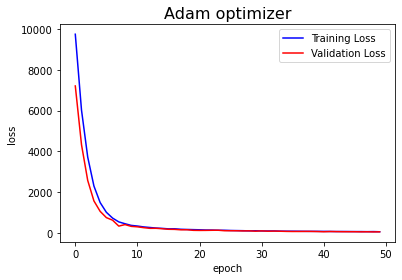

In [15]:
import matplotlib.pyplot as plt
# loss of stable model
epoch = np.arange(0 , len(md.history['loss']))

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , md.history['loss'] , color='b', label='Training Loss')
plt.plot(epoch , md.history['val_loss'] , color='r', label='Validation Loss')
plt.legend(loc='upper right')

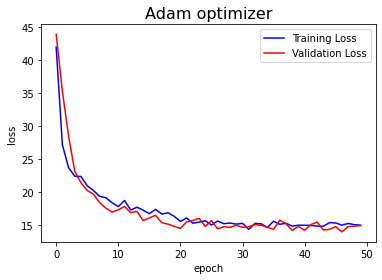

In [16]:
# loss of fine-tune model
epoch = np.arange(0 , len(md2.history['loss']))

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , md2.history['loss'] , color='b', label='Training Loss')
plt.plot(epoch , md2.history['val_loss'] , color='r', label='Validation Loss')
plt.legend(loc='upper right')

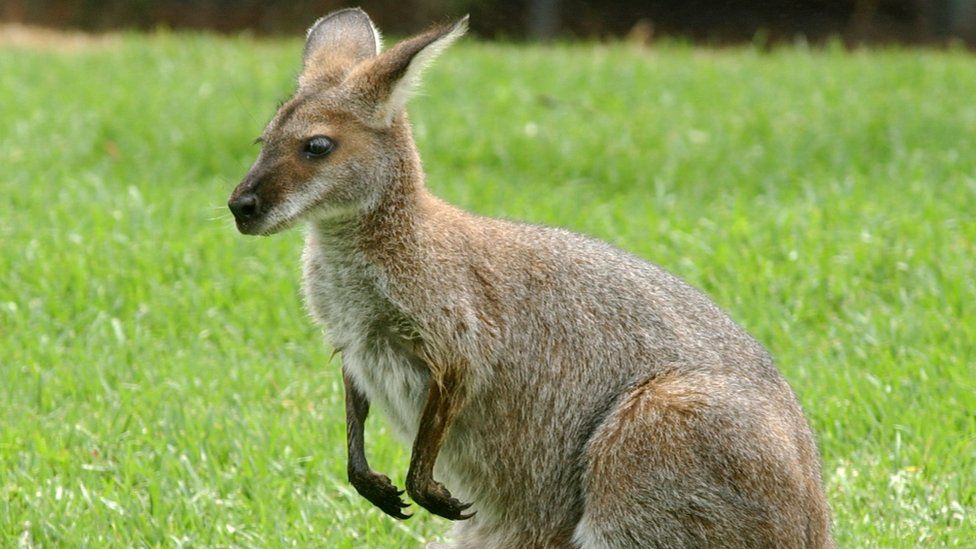

In [17]:
from PIL import Image
image = Image.open('./test_images/001.jpg')
image

In [18]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (280, 121) (803, 443)
kangaroo 0.94 (73, 40) (937, 517)
1.2478789579981822


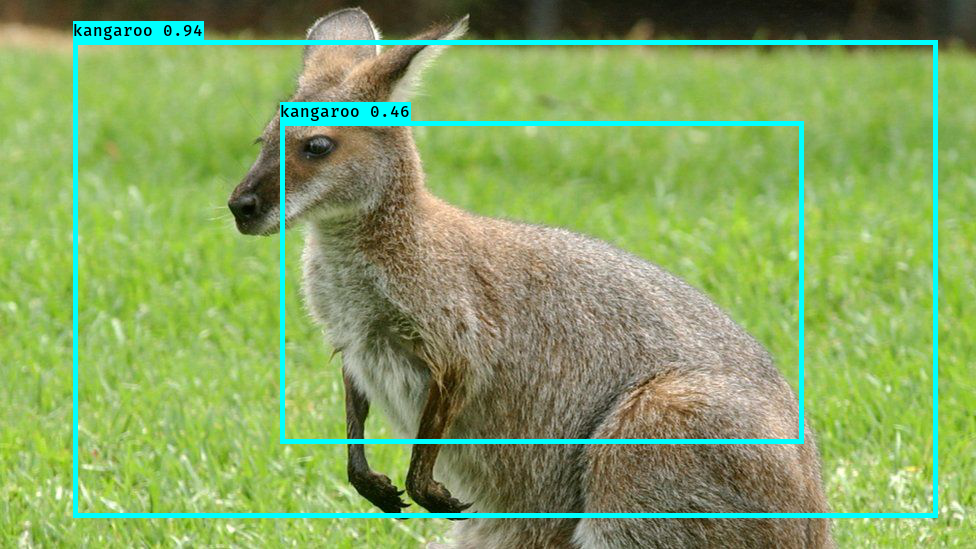

In [19]:
r_image

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 0) (990, 576)
0.16523350699571893


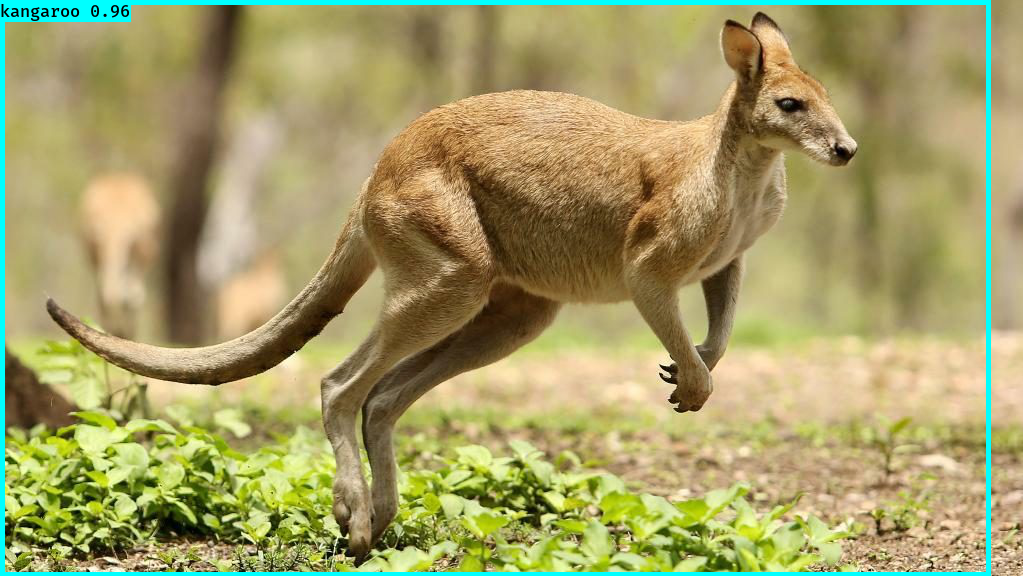

In [20]:
image = Image.open('./test_images/002.jpg') 
r_image = yolo_model.detect_image(image)
r_image

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (98, 0) (1199, 600)
0.17351725800108397


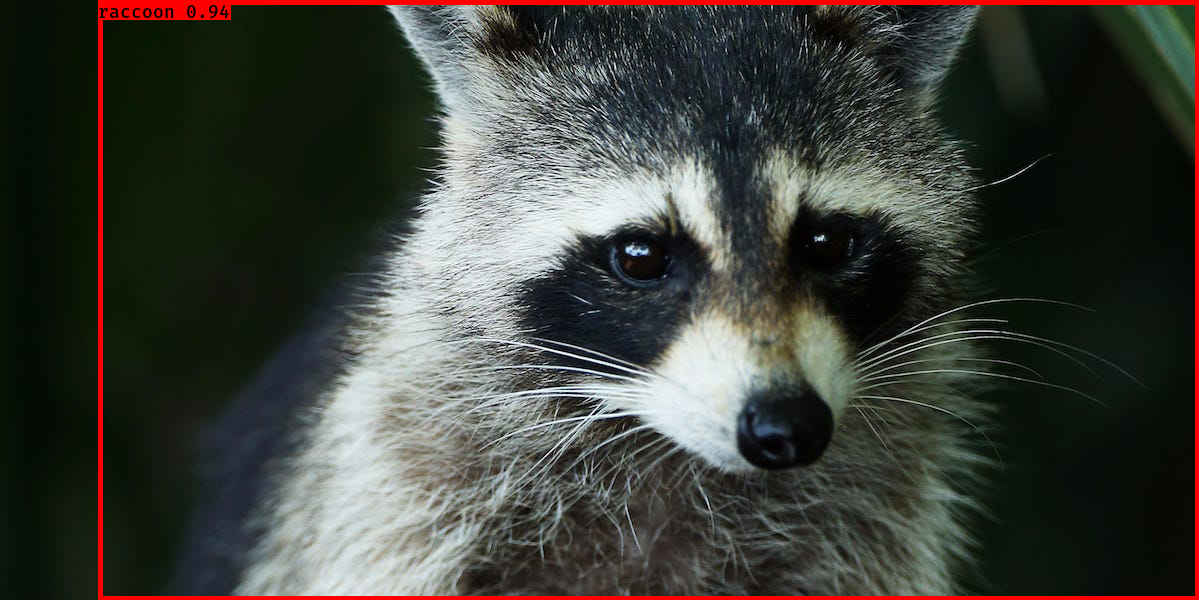

In [21]:
image = Image.open('./test_images/008.jpg')
r_image = yolo_model.detect_image(image)
r_image

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (62, 35) (537, 366)
0.15669286499905866


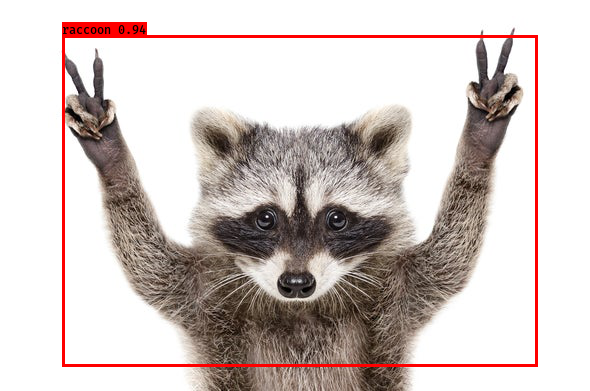

In [22]:
image = Image.open('./test_images/007.jpg')
r_image = yolo_model.detect_image(image)
r_image

In [23]:
def detect_video(yolo, video_path, output_path=""):

    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video!")

    # 取得影像的基本資訊
    video_FourCC = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')  # 指定 video 編碼方式(mp4)
    video_fps = vid.get(cv2.CAP_PROP_FPS)  # 總共有多少 frames
    video_size = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),   # 每個 frame 的寬
                  int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))  # 每個 frame 的高

    # 設定影像的輸出
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    # 初始化設定
    video_cnt = 0  
    video_playtime = []  

    # 迭代每個 frame 來進行影像偵測
    while True:
        return_value, frame = vid.read() # 讀取每個 frame
        video_cnt += 1 

        # 先把每個 frame 分開偵測，再把偵測完的 frames 串接回影片，最後輸出偵測好的影片
        if return_value == True: 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)  # 直接使用 yolo.py 的 detect_image 函式
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
        else:  
            break

    # 釋放資源
    vid.release()  # release input video resource
    out.release()  # release output video resource

    return video_playtime, video_cnt


In [24]:
import cv2
import time 

name = 'Kangaroo002'
video = './test_images/%s.mp4' % name
output = "./%s-out.mp4" % name
v_playtime, v_cnt = detect_video(yolo_model, video_path=video, output_path=output)
avg_fps = 1/np.mean(v_playtime)
avg_fps

(416, 416, 3)
Found 0 boxes for img
0.16030115600005956
(416, 416, 3)
Found 0 boxes for img
0.1525726530016982
(416, 416, 3)
Found 0 boxes for img
0.1479625220017624
(416, 416, 3)
Found 0 boxes for img
0.15103253200504696
(416, 416, 3)
Found 0 boxes for img
0.1656311539991293
(416, 416, 3)
Found 0 boxes for img
0.15158815999893704
(416, 416, 3)
Found 0 boxes for img
0.1502551650046371
(416, 416, 3)
Found 0 boxes for img
0.15292520200455328
(416, 416, 3)
Found 0 boxes for img
0.14925159900303697
(416, 416, 3)
Found 0 boxes for img
0.14974693400290562
(416, 416, 3)
Found 0 boxes for img
0.14848448999691755
(416, 416, 3)
Found 0 boxes for img
0.15331333000358427
(416, 416, 3)
Found 0 boxes for img
0.1477473060003831
(416, 416, 3)
Found 0 boxes for img
0.15211816399823874
(416, 416, 3)
Found 0 boxes for img
0.16345228199497797
(416, 416, 3)
Found 0 boxes for img
0.17542600599699654
(416, 416, 3)
Found 0 boxes for img
0.17608353400282795
(416, 416, 3)
Found 0 boxes for img
0.191605241998331

Found 0 boxes for img
0.17436484999780077
(416, 416, 3)
Found 0 boxes for img
0.17508372700103791
(416, 416, 3)
Found 0 boxes for img
0.17516736000106903
(416, 416, 3)
Found 0 boxes for img
0.17315729599795304
(416, 416, 3)
Found 0 boxes for img
0.1781705250032246
(416, 416, 3)
Found 0 boxes for img
0.174677082002745
(416, 416, 3)
Found 0 boxes for img
0.1939690029976191
(416, 416, 3)
Found 0 boxes for img
0.2019217999986722
(416, 416, 3)
Found 0 boxes for img
0.20607221299724188
(416, 416, 3)
Found 0 boxes for img
0.1933787759990082
(416, 416, 3)
Found 0 boxes for img
0.173794475995237
(416, 416, 3)
Found 0 boxes for img
0.18772462400374934
(416, 416, 3)
Found 0 boxes for img
0.17793895000068005
(416, 416, 3)
Found 0 boxes for img
0.17367286299850093
(416, 416, 3)
Found 0 boxes for img
0.17657535800390178
(416, 416, 3)
Found 0 boxes for img
0.17253221000282792
(416, 416, 3)
Found 0 boxes for img
0.17634298199845944
(416, 416, 3)
Found 0 boxes for img
0.1807823199997074
(416, 416, 3)
F

Found 0 boxes for img
0.17578423699887935
(416, 416, 3)
Found 0 boxes for img
0.17611890799889807
(416, 416, 3)
Found 0 boxes for img
0.1742311170019093
(416, 416, 3)
Found 0 boxes for img
0.17402394800592447
(416, 416, 3)
Found 0 boxes for img
0.1744946129983873
(416, 416, 3)
Found 0 boxes for img
0.17545238599996082
(416, 416, 3)
Found 0 boxes for img
0.17373048899753485
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (446, 179) (555, 302)
0.174784221999289
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (448, 186) (553, 299)
0.177269781997893
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (440, 181) (561, 302)
0.19663354100339347
(416, 416, 3)
Found 0 boxes for img
0.2217990849967464
(416, 416, 3)
Found 0 boxes for img
0.20247640600427985
(416, 416, 3)
Found 0 boxes for img
0.19797957700211555
(416, 416, 3)
Found 0 boxes for img
0.19963071399979526
(416, 416, 3)
Found 0 boxes for img
0.19564397100475617
(416, 416, 3)
Found 0 boxes for img
0.21469919600349385
(416, 416, 3)
Fou

Found 1 boxes for img
kangaroo 0.85 (214, 0) (540, 353)
0.17798293100349838
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (208, 0) (546, 351)
0.17419017200154485
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (211, 0) (544, 359)
0.17400479199568508
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (214, 0) (542, 355)
0.17444579899893142
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (214, 0) (542, 349)
0.17511644500336843
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (215, 0) (541, 351)
0.17560630699881585
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (215, 0) (542, 344)
0.17711051399965072
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (210, 3) (546, 341)
0.17770437499711988
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (211, 3) (546, 340)
0.1759222190012224
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (210, 3) (547, 340)
0.17615104500146117
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (206, 2) (550, 340)
0.1777337189996615
(416, 416, 3)
Found 1 boxe

Found 1 boxes for img
kangaroo 0.91 (204, 9) (542, 358)
0.17727345000457717
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (204, 7) (540, 360)
0.17506567200325662
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (200, 10) (544, 357)
0.17531084299844224
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (198, 17) (546, 349)
0.17344435599807184
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (199, 17) (547, 349)
0.17434921200037934
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (199, 17) (546, 349)
0.17436337300023297
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (203, 14) (545, 349)
0.17491173899907153
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (204, 20) (542, 344)
0.1740269250003621
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (201, 20) (548, 343)
0.17738880599790718
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (201, 15) (548, 347)
0.17459812999732094
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (202, 14) (546, 346)
0.19354916700103786
(416, 416, 3)
Fo

Found 0 boxes for img
0.1742325949962833
(416, 416, 3)
Found 0 boxes for img
0.17427291800413514
(416, 416, 3)
Found 0 boxes for img
0.18812862799677532
(416, 416, 3)
Found 0 boxes for img
0.19764264400146203
(416, 416, 3)
Found 0 boxes for img
0.19042156000068644
(416, 416, 3)
Found 0 boxes for img
0.19496344400249654
(416, 416, 3)
Found 0 boxes for img
0.17657673500070814
(416, 416, 3)
Found 0 boxes for img
0.18451163599820575
(416, 416, 3)
Found 0 boxes for img
0.1787992470053723
(416, 416, 3)
Found 0 boxes for img
0.17476516199531034
(416, 416, 3)
Found 0 boxes for img
0.17293879000499146
(416, 416, 3)
Found 0 boxes for img
0.17720913200173527
(416, 416, 3)
Found 0 boxes for img
0.17309840500092832
(416, 416, 3)
Found 0 boxes for img
0.1794252330000745
(416, 416, 3)
Found 0 boxes for img
0.17293643700395478
(416, 416, 3)
Found 0 boxes for img
0.17482269100582926
(416, 416, 3)
Found 0 boxes for img
0.17555339699902106
(416, 416, 3)
Found 0 boxes for img
0.17613559900200926
(416, 416

Found 1 boxes for img
kangaroo 0.35 (242, 73) (412, 303)
0.20403916599752847
(416, 416, 3)
Found 0 boxes for img
0.1956940329982899
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (233, 71) (411, 293)
0.19777478199830512
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (222, 95) (495, 275)
0.19310843600396765
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (231, 101) (484, 269)
0.17485190099978354
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (226, 102) (487, 262)
0.18772636100038653
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (219, 98) (496, 267)
0.18007728299562586
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (222, 97) (499, 269)
0.17432142599864164
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (230, 100) (497, 268)
0.17402081100590294
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (233, 93) (488, 272)
0.1757161109999288
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (238, 91) (475, 272)
0.1743005840035039
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.5

Found 1 boxes for img
kangaroo 0.58 (130, 0) (587, 360)
0.1731471329985652
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (90, 0) (553, 360)
0.17387020300520817
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (102, 0) (546, 359)
0.1745326159943943
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (96, 0) (541, 357)
0.1801341250029509
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (73, 0) (571, 360)
0.17860583100264193
(416, 416, 3)
Found 0 boxes for img
0.17664484899432864
(416, 416, 3)
Found 0 boxes for img
0.1746197230022517
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (143, 0) (493, 358)
0.17451442400488304
(416, 416, 3)
Found 0 boxes for img
0.1763057190037216
(416, 416, 3)
Found 0 boxes for img
0.1772563850026927
(416, 416, 3)
Found 0 boxes for img
0.1748715630019433
(416, 416, 3)
Found 0 boxes for img
0.17375985499529634
(416, 416, 3)
Found 0 boxes for img
0.17466301000240492
(416, 416, 3)
Found 0 boxes for img
0.17511605799518293
(416, 416, 3)
Found 0 boxes for img
0.175

Found 0 boxes for img
0.17496151800150983
(416, 416, 3)
Found 0 boxes for img
0.17396222200477496
(416, 416, 3)
Found 0 boxes for img
0.1742583899977035
(416, 416, 3)
Found 0 boxes for img
0.17379805899690837
(416, 416, 3)
Found 0 boxes for img
0.17507521499646828
(416, 416, 3)
Found 0 boxes for img
0.1750101529978565
(416, 416, 3)
Found 0 boxes for img
0.17304638299538055
(416, 416, 3)
Found 0 boxes for img
0.1740203939989442
(416, 416, 3)
Found 0 boxes for img
0.17604595000011614
(416, 416, 3)
Found 0 boxes for img
0.17582367999420967
(416, 416, 3)
Found 0 boxes for img
0.17698253599519376
(416, 416, 3)
Found 0 boxes for img
0.17287986100564012
(416, 416, 3)
Found 0 boxes for img
0.1754323179993662
(416, 416, 3)
Found 0 boxes for img
0.17613715900370153
(416, 416, 3)
Found 0 boxes for img
0.17683931699866662
(416, 416, 3)
Found 0 boxes for img
0.17461498099874007
(416, 416, 3)
Found 0 boxes for img
0.17583672900218517
(416, 416, 3)
Found 0 boxes for img
0.17498863800574327
(416, 416,

Found 1 boxes for img
raccoon 0.70 (0, 10) (249, 360)
0.17606111699569738
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (0, 0) (252, 360)
0.17616828699829057
(416, 416, 3)
Found 0 boxes for img
0.17580240999814123
(416, 416, 3)
Found 0 boxes for img
0.1755315310001606
(416, 416, 3)
Found 0 boxes for img
0.17389692600409035
(416, 416, 3)
Found 0 boxes for img
0.17316028100322
(416, 416, 3)
Found 0 boxes for img
0.1762866130011389
(416, 416, 3)
Found 0 boxes for img
0.17148936900048284
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (13, 24) (152, 351)
0.17507763100002194
(416, 416, 3)
Found 0 boxes for img
0.17393393399834167
(416, 416, 3)
Found 0 boxes for img
0.1743545159988571
(416, 416, 3)
Found 0 boxes for img
0.1742205870032194
(416, 416, 3)
Found 0 boxes for img
0.1768933260027552
(416, 416, 3)
Found 0 boxes for img
0.17539588599902345
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (0, 0) (141, 360)
0.17603271499683615
(416, 416, 3)
Found 0 boxes for img
0.17416636300185928

Found 1 boxes for img
kangaroo 0.67 (489, 198) (582, 360)
0.17727457000000868
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (487, 187) (587, 360)
0.17317784199985908
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (487, 200) (587, 360)
0.17541389200050617
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (489, 204) (586, 360)
0.17349434799689334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (490, 201) (587, 360)
0.1762738420002279
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (494, 209) (602, 360)
0.17526481199456612
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (492, 206) (604, 360)
0.17608356299751904
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (493, 213) (602, 356)
0.17554501500126207
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (495, 208) (603, 360)
0.17691693300002953
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (492, 205) (607, 360)
0.1751381180001772
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (497, 207) (603, 359)
0.17553160100214882
(416

Found 2 boxes for img
kangaroo 0.87 (0, 1) (364, 292)
kangaroo 0.87 (261, 63) (548, 324)
0.1925682169967331
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.83 (260, 60) (548, 329)
kangaroo 0.85 (5, 0) (358, 296)
0.199017377999553
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.78 (260, 62) (548, 327)
kangaroo 0.83 (5, 0) (360, 302)
0.19950372200401034
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.83 (259, 64) (546, 320)
kangaroo 0.83 (2, 0) (363, 302)
0.19677253300324082
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.81 (8, 0) (356, 302)
kangaroo 0.84 (256, 56) (547, 325)
0.1773736379982438
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.82 (5, 0) (359, 299)
kangaroo 0.91 (251, 51) (552, 326)
0.19232290299987653
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (38, 33) (370, 290)
kangaroo 0.92 (254, 53) (552, 327)
0.18253998200088972
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.79 (3, 0) (362, 302)
kangaroo 0.90 (256, 58) (552, 327)
0.17657681299897376
(416, 416, 3)
Found 2 boxes for 

Found 4 boxes for img
raccoon 0.72 (203, 60) (536, 308)
kangaroo 0.37 (271, 49) (538, 321)
kangaroo 0.50 (0, 78) (116, 211)
kangaroo 0.90 (0, 0) (386, 295)
0.1773048929971992
(416, 416, 3)
Found 3 boxes for img
raccoon 0.77 (213, 67) (522, 299)
kangaroo 0.52 (0, 78) (117, 211)
kangaroo 0.91 (0, 0) (376, 295)
0.1894216869986849
(416, 416, 3)
Found 4 boxes for img
raccoon 0.75 (215, 65) (527, 298)
kangaroo 0.30 (280, 47) (532, 315)
kangaroo 0.49 (0, 75) (117, 215)
kangaroo 0.93 (0, 0) (373, 291)
0.17723729799763532
(416, 416, 3)
Found 3 boxes for img
raccoon 0.81 (211, 54) (536, 309)
kangaroo 0.49 (0, 74) (113, 217)
kangaroo 0.91 (0, 0) (376, 305)
0.17916150200471748
(416, 416, 3)
Found 4 boxes for img
raccoon 0.77 (205, 56) (539, 307)
kangaroo 0.34 (268, 56) (537, 306)
kangaroo 0.45 (0, 74) (115, 216)
kangaroo 0.91 (0, 0) (379, 305)
0.1776348040002631
(416, 416, 3)
Found 4 boxes for img
raccoon 0.75 (209, 56) (543, 309)
kangaroo 0.31 (265, 60) (541, 305)
kangaroo 0.36 (0, 73) (118, 214)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 0) (640, 360)
0.19146850600373
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (0, 0) (640, 360)
0.17581241200241493
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (348, 31) (582, 293)
raccoon 0.48 (0, 0) (558, 360)
0.1911279010018916
(416, 416, 3)
Found 2 boxes for img
raccoon 0.51 (337, 43) (590, 290)
raccoon 0.66 (28, 0) (524, 360)
0.17892713600303978
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (347, 54) (580, 285)
raccoon 0.74 (36, 0) (513, 360)
0.17551957700197818
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (351, 49) (586, 292)
raccoon 0.85 (23, 0) (523, 360)
0.17567405499721644
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (356, 40) (591, 298)
raccoon 0.70 (2, 0) (544, 360)
0.17639691100339405
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 0) (557, 360)
0.1753402600006666
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (352, 56) (582, 226)
raccoon 0.75 (0, 0) (559, 360)
0.18186216300091473
(416, 416, 3)
F

(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (197, 57) (424, 304)
0.1953304649941856
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (225, 75) (412, 291)
0.19834220899792854
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (216, 57) (421, 310)
0.1964147709950339
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (260, 86) (447, 278)
0.17598635500326054
(416, 416, 3)
Found 0 boxes for img
0.18589236700063339
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (255, 60) (458, 314)
0.17907798300439026
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (33, 0) (504, 360)
0.17703820400492987
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (86, 0) (443, 360)
0.17622642599599203
(416, 416, 3)
Found 2 boxes for img
raccoon 0.39 (54, 0) (554, 360)
kangaroo 0.36 (24, 0) (541, 360)
0.1780582110004616
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (33, 0) (513, 360)
kangaroo 0.38 (33, 0) (513, 360)
0.1770712569996249
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (15, 0) (602, 356)
0.1784612109

Found 1 boxes for img
raccoon 0.83 (19, 13) (634, 332)
0.17577410800004145
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (48, 6) (610, 336)
0.1741526010009693
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (0, 0) (640, 351)
0.17488477200095076
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (72, 0) (586, 348)
0.17516048200195655
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (0, 0) (640, 360)
0.17845914900681237
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (23, 0) (630, 360)
0.17395513399969786
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 0) (640, 360)
0.17278937900118763
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (24, 0) (640, 360)
0.196621707000304
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (14, 0) (640, 360)
0.1940619989982224
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 0) (640, 360)
0.1996735919965431
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (7, 0) (633, 360)
0.20255603899568086
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0)

Found 2 boxes for img
kangaroo 0.76 (247, 81) (612, 316)
kangaroo 0.85 (71, 33) (353, 324)
0.177614888001699
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.70 (255, 79) (611, 319)
kangaroo 0.84 (31, 33) (390, 317)
0.1748594199962099
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (278, 115) (637, 301)
kangaroo 0.92 (66, 27) (359, 327)
0.1756116410033428
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (316, 83) (612, 314)
kangaroo 0.88 (57, 29) (368, 324)
0.17870257700269576
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (0, 0) (450, 360)
kangaroo 0.62 (313, 80) (604, 312)
kangaroo 0.91 (41, 26) (393, 331)
0.18131696999626
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (304, 79) (626, 314)
kangaroo 0.92 (39, 15) (407, 336)
0.1776999590001651
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.87 (53, 22) (389, 335)
kangaroo 0.90 (305, 59) (633, 331)
0.17615605700120796
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (26, 3) (430, 359)
kangaroo 0.91 (314, 61) (637, 324)
0.17575151

Found 3 boxes for img
kangaroo 0.33 (476, 242) (634, 341)
kangaroo 0.94 (8, 90) (305, 336)
kangaroo 0.96 (240, 66) (395, 292)
0.17607577199669322
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (476, 241) (634, 342)
kangaroo 0.91 (2, 91) (308, 336)
kangaroo 0.94 (241, 63) (401, 297)
0.20483054099895526
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (475, 240) (635, 342)
kangaroo 0.95 (251, 60) (394, 294)
kangaroo 0.95 (11, 91) (304, 337)
0.19541481899796054
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (475, 241) (634, 341)
kangaroo 0.92 (254, 55) (400, 305)
kangaroo 0.95 (9, 93) (305, 335)
0.1973356070011505
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (476, 240) (633, 343)
kangaroo 0.89 (251, 59) (406, 299)
kangaroo 0.94 (13, 104) (306, 325)
0.193672614004754
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (475, 241) (633, 343)
kangaroo 0.85 (236, 57) (411, 298)
kangaroo 0.93 (15, 100) (299, 329)
0.17427037400193512
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (4

Found 3 boxes for img
kangaroo 0.34 (479, 240) (630, 343)
kangaroo 0.61 (18, 72) (315, 360)
kangaroo 0.81 (201, 66) (454, 286)
0.17739040300511988
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (479, 240) (630, 343)
kangaroo 0.59 (0, 104) (281, 324)
kangaroo 0.85 (204, 73) (439, 284)
0.20342835300107254
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (478, 241) (631, 344)
kangaroo 0.62 (0, 101) (284, 328)
kangaroo 0.88 (209, 72) (445, 282)
0.2041530570058967
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (479, 240) (630, 343)
kangaroo 0.64 (0, 107) (274, 322)
kangaroo 0.88 (207, 78) (435, 276)
0.19614595799794188
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (477, 241) (631, 343)
kangaroo 0.61 (0, 93) (327, 343)
kangaroo 0.91 (208, 74) (439, 280)
0.1943788759963354
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (477, 241) (632, 343)
kangaroo 0.66 (0, 106) (277, 325)
kangaroo 0.88 (208, 77) (431, 277)
0.17797194999729982
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (

Found 3 boxes for img
kangaroo 0.32 (487, 243) (622, 341)
kangaroo 0.93 (0, 100) (256, 337)
kangaroo 0.96 (203, 47) (431, 321)
0.17605921599897556
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (487, 244) (622, 341)
kangaroo 0.94 (199, 48) (436, 315)
kangaroo 0.95 (0, 93) (268, 345)
0.17767679399548797
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (486, 245) (623, 340)
kangaroo 0.95 (0, 79) (276, 358)
kangaroo 0.98 (207, 52) (420, 312)
0.1772758770021028
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.30 (485, 245) (624, 340)
kangaroo 0.95 (0, 69) (284, 360)
kangaroo 0.97 (193, 52) (424, 316)
0.1768613979947986
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.94 (0, 77) (285, 355)
kangaroo 0.96 (178, 62) (433, 312)
0.17700085600517923
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.30 (485, 245) (625, 340)
kangaroo 0.94 (0, 88) (277, 342)
kangaroo 0.95 (187, 71) (422, 295)
0.17667916099890135
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (0, 88) (272, 343)
kangaroo 0.97 (197, 68

Found 2 boxes for img
kangaroo 0.87 (0, 81) (273, 343)
kangaroo 0.90 (200, 78) (415, 283)
0.18252379199839197
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.90 (0, 84) (270, 340)
kangaroo 0.94 (207, 74) (408, 288)
0.17927449999842793
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (0, 81) (274, 344)
kangaroo 0.93 (207, 70) (410, 294)
0.17896440599724883
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (157, 44) (397, 317)
kangaroo 0.89 (0, 88) (277, 336)
0.17662176400335738
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (209, 80) (398, 281)
kangaroo 0.93 (0, 86) (266, 340)
0.19866253500367748
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (5, 80) (260, 346)
kangaroo 0.94 (205, 81) (406, 286)
0.20147007900231984
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (0, 86) (267, 338)
kangaroo 0.95 (213, 71) (403, 295)
0.19338166099623777
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.90 (0, 89) (276, 333)
kangaroo 0.93 (212, 74) (417, 295)
0.1929021659962018
(416, 416, 3)
Found 2 b

(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (126, 81) (513, 256)
0.17507557199860457
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (126, 88) (523, 241)
0.18335383500379976
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (152, 85) (506, 247)
0.17971969300560886
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (191, 99) (521, 242)
kangaroo 0.36 (487, 4) (632, 352)
0.17908666300354525
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (398, 24) (636, 327)
raccoon 0.41 (189, 93) (519, 242)
0.17672667499573436
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (206, 91) (510, 240)
0.17811607500334503
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (195, 95) (532, 236)
0.17513553900062107
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (207, 91) (537, 239)
0.17970342300395714
(416, 416, 3)
Found 3 boxes for img
raccoon 0.34 (486, 42) (640, 306)
raccoon 0.81 (249, 83) (559, 255)
kangaroo 0.42 (486, 42) (640, 306)
0.17859060400223825
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (503

(416, 416, 3)
Found 2 boxes for img
raccoon 0.62 (0, 13) (228, 319)
kangaroo 0.82 (358, 83) (557, 312)
0.22401325299870223
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (5, 31) (219, 307)
kangaroo 0.82 (369, 65) (557, 331)
0.20809282700065523
(416, 416, 3)
Found 3 boxes for img
raccoon 0.62 (3, 27) (233, 309)
kangaroo 0.32 (34, 65) (215, 291)
kangaroo 0.87 (374, 52) (561, 340)
0.17961755499709398
(416, 416, 3)
Found 2 boxes for img
raccoon 0.74 (9, 28) (241, 308)
kangaroo 0.82 (391, 42) (554, 350)
0.20732350499747554
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (13, 31) (246, 305)
kangaroo 0.87 (395, 48) (552, 343)
0.173529283994867
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (24, 25) (247, 302)
kangaroo 0.89 (394, 54) (558, 331)
0.21599034799874062
(416, 416, 3)
Found 2 boxes for img
raccoon 0.39 (12, 51) (290, 277)
kangaroo 0.88 (401, 49) (556, 336)
0.17220676799479406
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (12, 42) (293, 282)
kangaroo 0.81 (394, 42) (571, 345)

Found 3 boxes for img
raccoon 0.65 (21, 37) (450, 263)
kangaroo 0.34 (21, 37) (450, 263)
kangaroo 0.38 (451, 87) (640, 241)
0.22029789700172842
(416, 416, 3)
Found 3 boxes for img
raccoon 0.68 (23, 30) (447, 269)
kangaroo 0.31 (23, 30) (447, 269)
kangaroo 0.35 (451, 90) (640, 239)
0.2047045680010342
(416, 416, 3)
Found 2 boxes for img
raccoon 0.76 (32, 33) (438, 263)
kangaroo 0.34 (452, 93) (640, 237)
0.19510536400048295
(416, 416, 3)
Found 2 boxes for img
raccoon 0.64 (25, 31) (446, 264)
kangaroo 0.38 (25, 31) (446, 264)
0.18735958600154845
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (20, 27) (452, 268)
kangaroo 0.43 (20, 27) (452, 268)
0.20415967799635837
(416, 416, 3)
Found 2 boxes for img
raccoon 0.58 (7, 22) (464, 274)
kangaroo 0.45 (7, 22) (464, 274)
0.1833453860017471
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (14, 27) (457, 274)
kangaroo 0.50 (14, 27) (457, 274)
0.17838385100185405
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (17, 32) (457, 268)
kangaroo 0.47 (17

Found 3 boxes for img
raccoon 0.76 (2, 18) (448, 271)
kangaroo 0.36 (2, 18) (448, 271)
kangaroo 0.59 (507, 110) (585, 235)
0.2197498750028899
(416, 416, 3)
Found 2 boxes for img
raccoon 0.82 (8, 24) (432, 259)
kangaroo 0.55 (510, 110) (585, 234)
0.18006922699714778
(416, 416, 3)
Found 4 boxes for img
raccoon 0.36 (493, 107) (609, 260)
raccoon 0.71 (8, 26) (427, 257)
kangaroo 0.37 (515, 111) (582, 236)
kangaroo 0.45 (8, 26) (427, 257)
0.17557052499614656
(416, 416, 3)
Found 3 boxes for img
raccoon 0.73 (0, 27) (428, 260)
kangaroo 0.41 (0, 27) (428, 260)
kangaroo 0.50 (495, 118) (611, 249)
0.17212408000341384
(416, 416, 3)
Found 3 boxes for img
raccoon 0.47 (485, 105) (613, 265)
raccoon 0.70 (0, 32) (429, 254)
kangaroo 0.42 (0, 32) (429, 254)
0.17494612799782772
(416, 416, 3)
Found 3 boxes for img
raccoon 0.54 (485, 95) (609, 279)
raccoon 0.70 (0, 33) (447, 252)
kangaroo 0.39 (0, 33) (447, 252)
0.1723987420045887
(416, 416, 3)
Found 4 boxes for img
raccoon 0.61 (479, 93) (615, 284)
racco

Found 3 boxes for img
kangaroo 0.80 (251, 146) (385, 275)
kangaroo 0.84 (501, 70) (617, 278)
kangaroo 0.93 (44, 29) (239, 302)
0.20310554900061106
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.67 (500, 67) (623, 273)
kangaroo 0.82 (252, 146) (382, 275)
kangaroo 0.95 (35, 42) (241, 291)
0.18930326100235106
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.79 (495, 70) (626, 276)
kangaroo 0.84 (247, 142) (379, 281)
kangaroo 0.96 (36, 43) (236, 291)
0.17711403800058179
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.67 (491, 68) (639, 282)
kangaroo 0.80 (245, 136) (377, 286)
kangaroo 0.96 (29, 47) (240, 287)
0.21670398700371152
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.67 (478, 70) (640, 279)
kangaroo 0.85 (250, 139) (379, 286)
kangaroo 0.96 (29, 50) (237, 282)
0.17682555099599995
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.79 (477, 74) (640, 277)
kangaroo 0.87 (257, 140) (381, 288)
kangaroo 0.97 (24, 52) (238, 283)
0.1775148909946438
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.75

Found 4 boxes for img
kangaroo 0.58 (496, 74) (640, 274)
kangaroo 0.75 (32, 82) (184, 307)
kangaroo 0.77 (122, 57) (389, 280)
kangaroo 0.81 (406, 143) (532, 285)
0.1811265559954336
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.62 (544, 41) (623, 299)
kangaroo 0.76 (415, 133) (550, 296)
kangaroo 0.76 (28, 71) (197, 322)
kangaroo 0.88 (150, 56) (378, 280)
0.18377286400209414
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.56 (415, 141) (582, 288)
kangaroo 0.70 (32, 35) (211, 356)
kangaroo 0.79 (557, 44) (628, 299)
kangaroo 0.93 (165, 52) (369, 287)
0.17944253099994967
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.46 (25, 0) (232, 360)
kangaroo 0.76 (441, 143) (575, 283)
kangaroo 0.90 (563, 45) (628, 295)
kangaroo 0.93 (170, 37) (372, 301)
0.18094136199943023
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.79 (456, 137) (580, 288)
kangaroo 0.85 (191, 20) (369, 323)
kangaroo 0.87 (569, 56) (640, 283)
0.17603225000493694
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (31, 128) (235, 299)

Found 0 boxes for img
0.17713357400498353
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 0) (269, 350)
0.17379479800001718
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (36, 0) (301, 297)
0.17710390200227266
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (25, 2) (339, 296)
0.17626582299999427
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (96, 0) (333, 302)
0.17646246100048302
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (70, 5) (384, 295)
0.17499613399559166
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (76, 0) (392, 297)
0.17828968099638587
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (147, 24) (407, 270)
0.1734380850029993
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (135, 5) (427, 295)
0.18159512399870437
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (171, 43) (460, 255)
raccoon 0.63 (0, 104) (313, 329)
0.17631171399989398
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (0, 85) (359, 340)
raccoon 0.67 (188, 26) (467, 265)
0.1774684529955266
(416, 416

Found 1 boxes for img
kangaroo 0.93 (346, 15) (640, 327)
0.17743681400315836
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (336, 12) (640, 340)
0.1734091860053013
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (0, 0) (239, 360)
kangaroo 0.79 (343, 8) (640, 341)
0.18030814899975667
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (463, 47) (626, 310)
kangaroo 0.76 (347, 8) (640, 341)
0.17542441499972483
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (453, 20) (635, 333)
kangaroo 0.68 (346, 0) (640, 360)
0.17831178699998418
(416, 416, 3)
Found 2 boxes for img
raccoon 0.69 (0, 11) (242, 252)
kangaroo 0.75 (458, 8) (632, 346)
0.17682013699959498
(416, 416, 3)
Found 2 boxes for img
raccoon 0.56 (24, 12) (221, 225)
kangaroo 0.90 (449, 12) (640, 342)
0.19546009699843125
(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (42, 32) (261, 218)
kangaroo 0.86 (444, 19) (640, 335)
0.20092264900449663
(416, 416, 3)
Found 2 boxes for img
raccoon 0.83 (53, 11) (253, 232)
kangaroo 0.82 (449, 24)

0.1974582240000018
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (74, 0) (333, 329)
kangaroo 0.91 (357, 1) (591, 263)
0.19522452599630924
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (0, 21) (441, 280)
kangaroo 0.83 (79, 0) (331, 360)
kangaroo 0.92 (360, 0) (601, 287)
0.17752788299549138
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.70 (68, 0) (346, 342)
kangaroo 0.90 (406, 0) (586, 278)
0.195134298002813
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.72 (53, 0) (375, 326)
kangaroo 0.92 (401, 0) (598, 273)
0.1773376159981126
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.79 (63, 2) (385, 317)
kangaroo 0.95 (397, 0) (613, 269)
0.17877358799887588
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.79 (80, 9) (370, 310)
kangaroo 0.88 (405, 0) (623, 293)
0.17520113100181334
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (400, 0) (640, 284)
kangaroo 0.75 (123, 0) (388, 360)
0.17933256200194592
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (0, 19) (527, 281)
kangaroo 0.71 (114, 

Found 3 boxes for img
raccoon 0.82 (136, 0) (444, 356)
kangaroo 0.39 (127, 26) (473, 333)
kangaroo 0.89 (353, 0) (640, 304)
0.18055395500414306
(416, 416, 3)
Found 3 boxes for img
raccoon 0.83 (137, 4) (444, 351)
kangaroo 0.35 (132, 25) (467, 333)
kangaroo 0.91 (350, 0) (640, 302)
0.1824858849940938
(416, 416, 3)
Found 2 boxes for img
raccoon 0.90 (145, 22) (435, 331)
kangaroo 0.89 (358, 0) (640, 299)
0.19945522600028198
(416, 416, 3)
Found 3 boxes for img
raccoon 0.80 (146, 20) (432, 343)
kangaroo 0.47 (140, 33) (459, 331)
kangaroo 0.90 (350, 2) (640, 290)
0.2058835820062086
(416, 416, 3)
Found 3 boxes for img
raccoon 0.78 (158, 20) (422, 351)
kangaroo 0.48 (145, 34) (457, 336)
kangaroo 0.90 (350, 0) (640, 296)
0.205261094000889
(416, 416, 3)
Found 3 boxes for img
raccoon 0.85 (158, 26) (418, 353)
kangaroo 0.34 (131, 38) (469, 339)
kangaroo 0.90 (351, 0) (640, 298)
0.18271156199625693
(416, 416, 3)
Found 3 boxes for img
raccoon 0.78 (155, 28) (419, 354)
kangaroo 0.53 (125, 56) (475, 3

(416, 416, 3)
Found 3 boxes for img
raccoon 0.67 (156, 11) (454, 352)
kangaroo 0.47 (156, 11) (454, 352)
kangaroo 0.88 (346, 10) (640, 280)
0.2037201940038358
(416, 416, 3)
Found 3 boxes for img
raccoon 0.75 (158, 13) (450, 350)
kangaroo 0.38 (158, 13) (450, 350)
kangaroo 0.86 (345, 9) (640, 281)
0.18710863999876892
(416, 416, 3)
Found 3 boxes for img
raccoon 0.76 (156, 13) (451, 351)
kangaroo 0.35 (156, 13) (451, 351)
kangaroo 0.90 (350, 7) (640, 284)
0.1854898149977089
(416, 416, 3)
Found 3 boxes for img
raccoon 0.71 (157, 12) (450, 350)
kangaroo 0.42 (157, 12) (450, 350)
kangaroo 0.89 (342, 9) (640, 282)
0.19158575400069822
(416, 416, 3)
Found 3 boxes for img
raccoon 0.71 (157, 13) (450, 348)
kangaroo 0.43 (157, 13) (450, 348)
kangaroo 0.90 (343, 0) (640, 295)
0.17863397500332212
(416, 416, 3)
Found 3 boxes for img
raccoon 0.77 (155, 12) (452, 349)
kangaroo 0.35 (155, 12) (452, 349)
kangaroo 0.90 (348, 0) (640, 296)
0.18081366900150897
(416, 416, 3)
Found 3 boxes for img
raccoon 0.7

Found 4 boxes for img
raccoon 0.51 (172, 38) (451, 322)
kangaroo 0.52 (384, 136) (640, 298)
kangaroo 0.66 (384, 55) (640, 223)
kangaroo 0.66 (172, 38) (451, 322)
0.1769749960003537
(416, 416, 3)
Found 4 boxes for img
raccoon 0.49 (172, 34) (455, 324)
kangaroo 0.43 (390, 133) (640, 301)
kangaroo 0.53 (386, 62) (640, 215)
kangaroo 0.67 (172, 34) (455, 324)
0.1779834480039426
(416, 416, 3)
Found 3 boxes for img
raccoon 0.38 (179, 40) (449, 316)
kangaroo 0.71 (409, 97) (640, 258)
kangaroo 0.74 (179, 40) (449, 316)
0.17961805599770742
(416, 416, 3)
Found 3 boxes for img
raccoon 0.43 (177, 36) (449, 324)
kangaroo 0.71 (177, 36) (449, 324)
kangaroo 0.74 (407, 90) (640, 262)
0.17645629999606172
(416, 416, 3)
Found 3 boxes for img
raccoon 0.45 (177, 40) (451, 321)
kangaroo 0.69 (177, 40) (451, 321)
kangaroo 0.77 (409, 98) (639, 256)
0.18188190999353537
(416, 416, 3)
Found 3 boxes for img
raccoon 0.40 (181, 43) (449, 318)
kangaroo 0.72 (181, 43) (449, 318)
kangaroo 0.76 (408, 94) (640, 256)
0.17

Found 3 boxes for img
raccoon 0.65 (186, 39) (471, 307)
kangaroo 0.36 (186, 39) (471, 307)
kangaroo 0.79 (405, 83) (640, 256)
0.17843041100422852
(416, 416, 3)
Found 3 boxes for img
raccoon 0.75 (188, 38) (470, 309)
kangaroo 0.31 (213, 53) (481, 307)
kangaroo 0.77 (403, 84) (640, 256)
0.17647360200498952
(416, 416, 3)
Found 3 boxes for img
raccoon 0.67 (188, 36) (470, 311)
kangaroo 0.35 (188, 36) (470, 311)
kangaroo 0.77 (405, 86) (640, 256)
0.1776906439990853
(416, 416, 3)
Found 3 boxes for img
raccoon 0.80 (193, 37) (465, 311)
kangaroo 0.31 (215, 53) (479, 311)
kangaroo 0.76 (399, 84) (640, 258)
0.1749606980010867
(416, 416, 3)
Found 3 boxes for img
raccoon 0.76 (189, 39) (466, 306)
kangaroo 0.30 (210, 57) (484, 303)
kangaroo 0.77 (367, 41) (640, 254)
0.1983735730027547
(416, 416, 3)
Found 3 boxes for img
raccoon 0.68 (189, 41) (469, 305)
kangaroo 0.44 (202, 61) (493, 298)
kangaroo 0.84 (393, 82) (640, 257)
0.19812606100458652
(416, 416, 3)
Found 3 boxes for img
raccoon 0.72 (188, 41

(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (438, 24) (640, 297)
kangaroo 0.55 (442, 16) (640, 283)
0.2001138199993875
(416, 416, 3)
Found 2 boxes for img
raccoon 0.39 (440, 28) (640, 293)
kangaroo 0.47 (442, 19) (640, 282)
0.19422989599843277
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (447, 34) (640, 288)
kangaroo 0.47 (442, 15) (640, 288)
0.1777994599979138
(416, 416, 3)
Found 2 boxes for img
raccoon 0.51 (441, 30) (640, 295)
kangaroo 0.45 (446, 14) (640, 291)
0.19075762300053611
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (450, 17) (640, 309)
0.18020639699534513
(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (444, 0) (640, 310)
kangaroo 0.32 (444, 0) (640, 310)
0.17643143400346162
(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (373, 0) (640, 312)
kangaroo 0.57 (373, 0) (640, 312)
0.1777313740021782
(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (374, 0) (640, 301)
kangaroo 0.49 (374, 0) (640, 301)
0.17615412299346644
(416, 416, 3)
Found 2 boxes for img
raccoon 

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (470, 179) (535, 339)
kangaroo 0.84 (181, 2) (395, 360)
0.1793110219950904
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (471, 176) (534, 342)
kangaroo 0.85 (186, 0) (391, 360)
0.19758338000247022
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (463, 167) (541, 350)
kangaroo 0.85 (185, 0) (392, 360)
0.18253790200105868
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (470, 190) (527, 300)
kangaroo 0.45 (463, 166) (541, 350)
kangaroo 0.85 (201, 56) (400, 311)
0.17624953199992888
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (469, 188) (528, 301)
kangaroo 0.87 (206, 58) (395, 309)
0.1749712439996074
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (463, 167) (539, 349)
kangaroo 0.85 (203, 62) (399, 302)
0.17831884399492992
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (463, 174) (538, 343)
kangaroo 0.85 (201, 65) (401, 299)
0.17696012500528013
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (464, 173) (535, 344)
kangaroo

Found 3 boxes for img
kangaroo 0.38 (414, 192) (526, 332)
kangaroo 0.73 (427, 125) (501, 360)
kangaroo 0.97 (183, 12) (417, 353)
0.18052897099551046
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (425, 133) (502, 360)
kangaroo 0.97 (188, 12) (412, 349)
0.17357439700572286
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (424, 151) (502, 360)
kangaroo 0.96 (186, 12) (415, 353)
0.1804626779994578
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (425, 165) (498, 360)
kangaroo 0.96 (186, 17) (415, 350)
0.17535339899768587
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (420, 157) (503, 360)
kangaroo 0.96 (183, 18) (417, 351)
0.19519085600040853
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.80 (424, 167) (497, 357)
kangaroo 0.95 (184, 18) (416, 348)
0.20016845600184752
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (425, 175) (492, 351)
kangaroo 0.95 (186, 17) (415, 351)
0.1961353799997596
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.87 (427, 181) (491, 346)
kangaroo 0.93 (185,

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (383, 224) (472, 317)
kangaroo 0.91 (172, 47) (427, 310)
0.1768505579966586
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (386, 211) (471, 352)
kangaroo 0.91 (173, 43) (426, 315)
0.17701912900520256
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (387, 212) (472, 350)
kangaroo 0.91 (172, 39) (427, 318)
0.17427741100254934
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (379, 222) (472, 320)
kangaroo 0.88 (172, 39) (427, 319)
0.18808284500119044
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (385, 208) (470, 355)
kangaroo 0.88 (174, 40) (425, 319)
0.1805977999974857
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (380, 209) (473, 355)
kangaroo 0.89 (174, 39) (425, 318)
0.18310311999812257
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (379, 213) (473, 351)
kangaroo 0.88 (173, 39) (426, 314)
0.17470095200405922
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (381, 209) (470, 356)
kangaroo 0.85 (172, 38) (426, 315)
0.1760

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (329, 288) (438, 355)
kangaroo 0.94 (128, 0) (428, 352)
0.19348458899912657
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (329, 290) (438, 352)
kangaroo 0.94 (126, 0) (427, 345)
0.17776583199884044
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (333, 292) (435, 352)
kangaroo 0.95 (129, 1) (422, 341)
0.19384000499849208
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (330, 290) (436, 354)
kangaroo 0.94 (116, 10) (429, 331)
0.17714586499641882
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (327, 291) (438, 355)
kangaroo 0.96 (128, 12) (416, 329)
0.17808090899779927
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (329, 290) (436, 357)
kangaroo 0.95 (122, 19) (425, 323)
0.1749427899994771
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (115, 22) (431, 321)
0.21213926099881064
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (122, 19) (424, 325)
0.21977802400215296
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (134, 26) 

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (173, 43) (363, 353)
0.20287168500362895
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (172, 42) (362, 354)
0.19782761100213975
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (173, 44) (363, 354)
0.1978022740004235
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (170, 45) (368, 352)
0.17298824599856744
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (171, 48) (368, 349)
0.18759116499859374
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (172, 44) (368, 351)
0.17546016599953873
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (174, 45) (366, 350)
0.17705901699810056
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (173, 52) (368, 345)
0.1728145249944646
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (174, 56) (367, 340)
0.17634199500025716
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (171, 61) (369, 335)
0.17463618100009626
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (172, 62) (368, 334)
0.1842499839985976
(4

Found 1 boxes for img
kangaroo 0.81 (153, 108) (321, 310)
0.18015443599870196
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (152, 106) (322, 311)
0.1777812479995191
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (146, 108) (329, 309)
0.17923153399897274
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (141, 112) (332, 305)
0.17338258100062376
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (140, 117) (332, 300)
0.17635523100034334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (140, 118) (332, 300)
0.1759555980024743
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (140, 116) (332, 301)
0.20433738100109622
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (139, 116) (333, 301)
0.19870903200353496
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (140, 115) (331, 302)
0.1985859749984229
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (141, 112) (330, 304)
0.19274346599559067
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (141, 109) (330, 307)
0.17865024799539242
(416,

Found 1 boxes for img
kangaroo 0.68 (253, 121) (447, 295)
0.17619033200026024
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (252, 120) (448, 296)
0.17554886099969735
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (250, 120) (450, 296)
0.1805625950000831
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (249, 120) (450, 296)
0.17603420600062236
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (251, 121) (448, 295)
0.17796397699567024
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (250, 120) (449, 295)
0.17526112100313185
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (251, 122) (448, 294)
0.17502754399902187
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (249, 123) (449, 296)
0.17433447900111787
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (248, 122) (449, 296)
0.17505898499803152
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (248, 121) (449, 297)
0.17578393499570666
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (242, 83) (433, 332)
0.177951440004108
(416, 

Found 1 boxes for img
kangaroo 0.87 (128, 85) (501, 334)
0.18275197700131685
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (130, 91) (495, 329)
0.1806902070020442
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (131, 95) (490, 324)
0.1801508680000552
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (123, 94) (496, 324)
0.17875422799988883
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (124, 91) (497, 326)
0.19327594800415682
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (129, 95) (491, 323)
0.2083574319985928
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (139, 97) (478, 320)
0.19813007099583047
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (146, 90) (473, 327)
0.2194143289962085
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (157, 89) (462, 328)
0.19511319499724777
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (158, 84) (457, 333)
0.19014986499678344
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (160, 85) (454, 332)
0.19938702600484248
(416, 416, 3)
Fou

Found 1 boxes for img
kangaroo 0.89 (173, 18) (406, 332)
0.18870184399565915
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (174, 16) (406, 335)
0.2009978170026443
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (201, 48) (405, 296)
0.18183184800000163
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (198, 47) (409, 295)
0.18271743600053014
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (196, 46) (410, 296)
0.17493800499505596
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (200, 50) (408, 293)
0.1830081469961442
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (199, 52) (411, 292)
0.18700523599545704
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (197, 53) (415, 290)
0.20252368700312218
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (200, 55) (416, 288)
0.2012997380006709
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (198, 52) (419, 293)
0.20539908100181492
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (200, 48) (417, 297)
0.1983801640017191
(416, 416, 3)
Fou

Found 1 boxes for img
kangaroo 0.95 (185, 38) (419, 324)
0.17737379299796885
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (184, 41) (420, 318)
0.17874241399840685
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (185, 44) (418, 311)
0.18026928199833492
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (185, 40) (418, 314)
0.20106295900041005
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (187, 45) (416, 307)
0.1907013370000641
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (185, 47) (417, 305)
0.20565583300049184
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (181, 51) (421, 301)
0.2035490479975124
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (180, 49) (422, 302)
0.2310282590042334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (183, 54) (420, 294)
0.22905180000088876
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (144, 16) (410, 343)
0.2145889960011118
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (145, 18) (412, 338)
0.19750859399937326
(416, 416, 3)
Fou

0.19825097799912328
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (134, 21) (495, 335)
0.20477467300224816
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (137, 21) (492, 336)
0.21184397600154625
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (137, 21) (492, 335)
0.2337552989993128
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (138, 23) (492, 332)
0.20020575699891197
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (140, 24) (490, 332)
0.22113357199850725
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (137, 22) (492, 333)
0.1764120029984042
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (136, 21) (493, 334)
0.17348543099797098
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (136, 22) (493, 333)
0.1746452439983841
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (140, 22) (490, 333)
0.1848280470003374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (140, 23) (491, 331)
0.17701423200196587
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (139, 25) (490, 329)
0.175937150997

Found 2 boxes for img
kangaroo 0.81 (372, 45) (640, 321)
kangaroo 0.97 (0, 0) (321, 346)
0.18323219200101448
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.79 (362, 44) (640, 322)
kangaroo 0.95 (0, 0) (336, 360)
0.18007392599974992
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (367, 45) (640, 318)
kangaroo 0.91 (0, 0) (320, 351)
0.17993137800658587
(416, 416, 3)
Found 3 boxes for img
raccoon 0.57 (370, 44) (640, 322)
kangaroo 0.44 (370, 44) (640, 322)
kangaroo 0.86 (21, 0) (295, 342)
0.17937488699681126
(416, 416, 3)
Found 3 boxes for img
raccoon 0.38 (376, 32) (640, 333)
kangaroo 0.62 (376, 32) (640, 333)
kangaroo 0.89 (14, 0) (298, 360)
0.17885197999567026
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (378, 30) (640, 341)
kangaroo 0.90 (27, 0) (285, 345)
0.17773979600315215
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (387, 36) (640, 331)
kangaroo 0.91 (35, 0) (280, 343)
0.18241117499565007
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (389, 28) (640, 344)
kangaroo 0

Found 1 boxes for img
kangaroo 0.52 (262, 223) (352, 293)
0.17796859300142387
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (264, 230) (344, 287)
0.17593859999760753
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (209, 235) (375, 288)
0.1877254190039821
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (223, 228) (361, 296)
0.20832558599795448
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (226, 227) (357, 295)
0.21243897800013656
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (216, 228) (367, 295)
0.17944270400039386
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (222, 226) (361, 297)
0.17825627800630173
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (227, 228) (355, 297)
0.17612279399327235
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (236, 228) (342, 293)
0.18338101800327422
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (234, 228) (338, 293)
0.18475024099461734
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (229, 229) (338, 293)
0.20440063800197095
(41

Found 1 boxes for img
raccoon 0.95 (169, 30) (584, 329)
0.17790721300116275
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (168, 29) (587, 331)
0.19697286600421648
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (169, 29) (586, 331)
0.197368835004454
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (165, 25) (590, 334)
0.17441739200148731
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (163, 27) (592, 332)
0.17660767100460362
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (163, 26) (591, 332)
0.17930771299870685
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (164, 25) (592, 332)
0.17833414200140396
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (164, 27) (592, 332)
0.17787528299959376
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (163, 27) (592, 333)
0.18531963499845006
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (160, 22) (596, 337)
0.18270085500262212
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (168, 21) (587, 343)
0.18086921999929473
(416, 416, 3)
Found 1 boxe

(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (289, 5) (637, 360)
0.2044092180003645
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (293, 0) (634, 360)
0.19785739100188948
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (367, 0) (576, 360)
0.1806449879950378
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (366, 0) (579, 360)
0.18184407999797259
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (372, 0) (574, 360)
0.19233625599736115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (371, 0) (573, 360)
0.1843044679990271
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (370, 0) (576, 360)
0.17959657000028528
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (369, 0) (575, 360)
0.17864837199886097
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (369, 0) (576, 360)
0.18996807000075933
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (369, 0) (573, 360)
0.18953111799783073
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (367, 0) (573, 360)
0.19000780599890277
(416, 416, 3)
Found 1 bo

Found 0 boxes for img
0.17607881600270048
(416, 416, 3)
Found 0 boxes for img
0.17979285500041442
(416, 416, 3)
Found 0 boxes for img
0.1801688510022359
(416, 416, 3)
Found 0 boxes for img
0.18119739700341597
(416, 416, 3)
Found 0 boxes for img
0.1901042960016639
(416, 416, 3)
Found 0 boxes for img
0.18600017900462262
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (173, 0) (640, 360)
0.20443230599630624
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (190, 0) (634, 360)
0.23922169399884297
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (193, 0) (630, 360)
0.22021526900061872
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (187, 0) (633, 360)
0.2431541969999671
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (199, 0) (619, 360)
kangaroo 0.33 (199, 0) (619, 360)
0.21367759099666728
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (167, 0) (640, 360)
0.18475735000538407
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (181, 0) (634, 360)
0.1846157559994026
(416, 416, 3)
Found 1 

Found 3 boxes for img
kangaroo 0.45 (480, 178) (538, 318)
kangaroo 0.79 (306, 97) (522, 332)
kangaroo 0.80 (69, 25) (182, 337)
0.178512389997195
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.58 (479, 178) (541, 318)
kangaroo 0.73 (300, 102) (526, 328)
kangaroo 0.80 (66, 26) (184, 338)
0.19747702199674677
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.61 (479, 178) (540, 318)
kangaroo 0.73 (300, 99) (526, 329)
kangaroo 0.78 (63, 24) (187, 342)
0.21690159200079506
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.66 (477, 178) (541, 318)
kangaroo 0.74 (297, 100) (522, 328)
kangaroo 0.80 (63, 22) (186, 343)
0.18111048800346907
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.67 (479, 175) (539, 318)
kangaroo 0.78 (299, 99) (521, 327)
kangaroo 0.82 (64, 25) (186, 338)
0.21383010099816602
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.71 (477, 176) (539, 317)
kangaroo 0.77 (295, 98) (522, 326)
kangaroo 0.81 (60, 24) (188, 339)
0.21770031299820403
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.6

Found 3 boxes for img
kangaroo 0.59 (146, 0) (304, 345)
kangaroo 0.72 (25, 3) (163, 353)
kangaroo 0.79 (460, 177) (553, 318)
0.18427618200075813
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.66 (147, 4) (294, 337)
kangaroo 0.74 (0, 19) (215, 340)
kangaroo 0.78 (461, 179) (550, 315)
0.18525811900326516
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.72 (27, 18) (159, 332)
kangaroo 0.77 (145, 7) (286, 335)
kangaroo 0.77 (463, 178) (549, 317)
0.18878457799291937
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.73 (27, 25) (158, 323)
kangaroo 0.75 (140, 0) (284, 342)
kangaroo 0.77 (468, 176) (548, 319)
0.1897541310027009
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.72 (28, 29) (156, 322)
kangaroo 0.75 (471, 176) (544, 320)
kangaroo 0.84 (137, 0) (286, 352)
0.18700395400082925
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.70 (468, 188) (548, 307)
kangaroo 0.77 (27, 22) (157, 332)
kangaroo 0.86 (131, 5) (288, 343)
0.18611696700099856
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.64 (466, 1

Found 1 boxes for img
kangaroo 0.59 (114, 61) (406, 342)
0.24319948899938026
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (104, 64) (417, 340)
0.21558756699960213
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (136, 0) (340, 360)
0.20387077699706424
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (143, 3) (334, 360)
0.1970880689987098
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (128, 68) (379, 335)
0.24477829199895496
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (122, 62) (384, 341)
0.23473740400368115
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (129, 62) (377, 341)
0.2235420439974405
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (137, 60) (371, 345)
0.21225921800214564
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (144, 82) (365, 323)
0.2071917239954928
(416, 416, 3)
Found 0 boxes for img
0.2397312020038953
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (164, 80) (348, 324)
0.27512882400333183
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (173

0.19731160300580086
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (319, 80) (633, 314)
kangaroo 0.80 (108, 105) (250, 339)
0.18115127599594416
(416, 416, 3)
Found 3 boxes for img
raccoon 0.30 (317, 79) (635, 315)
kangaroo 0.65 (317, 79) (635, 315)
kangaroo 0.80 (109, 104) (248, 340)
0.1807695860043168
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (318, 80) (634, 315)
kangaroo 0.80 (111, 102) (246, 343)
0.17904949999501696
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (316, 78) (637, 317)
kangaroo 0.80 (112, 99) (244, 347)
0.17720376500074053
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (319, 79) (635, 315)
kangaroo 0.80 (111, 99) (245, 347)
0.19061837399931392
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (319, 80) (634, 315)
kangaroo 0.80 (111, 102) (246, 343)
0.18453240200324217
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (318, 80) (636, 315)
kangaroo 0.81 (111, 102) (247, 344)
0.18314613300026394
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (317, 80) 

Found 1 boxes for img
kangaroo 0.83 (133, 0) (442, 348)
0.22344763499859255
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (226, 70) (640, 360)
kangaroo 0.90 (106, 26) (442, 324)
0.2210255500031053
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (87, 0) (470, 360)
0.2176873189964681
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (77, 8) (469, 357)
0.2072357849974651
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (5, 0) (640, 360)
0.1870915489998879
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (56, 0) (607, 350)
0.19662538500415394
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (63, 0) (598, 360)
0.20321515899559017
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (61, 0) (600, 360)
0.18469489400013117
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (0, 0) (547, 360)
0.1938843000025372
(416, 416, 3)
Found 0 boxes for img
0.20795158600230934
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (13, 0) (632, 360)
0.22369217399682384
(416, 416, 3)
Found 1 boxes for img
ka

Found 1 boxes for img
raccoon 0.97 (0, 0) (640, 360)
0.18958008800109383
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (0, 0) (640, 360)
0.1958026670035906
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (278, 90) (640, 360)
raccoon 0.83 (0, 0) (640, 360)
0.20702041500044288
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (0, 0) (640, 360)
0.20817795999755617
(416, 416, 3)
Found 0 boxes for img
0.20807359000173165
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (0, 0) (640, 360)
0.18401731100311736
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 0) (640, 360)
0.1969071250059642
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (640, 360)
0.18486689199926332
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 0) (640, 360)
0.18222178899304708
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (0, 0) (640, 360)
0.22304254100163234
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (4, 0) (634, 360)
0.24910528800683096
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) 

Found 2 boxes for img
raccoon 0.44 (285, 127) (542, 318)
raccoon 0.76 (121, 88) (434, 348)
0.21304628800135106
(416, 416, 3)
Found 2 boxes for img
raccoon 0.55 (272, 118) (547, 325)
raccoon 0.69 (101, 100) (447, 336)
0.22130767399357865
(416, 416, 3)
Found 3 boxes for img
raccoon 0.50 (99, 99) (439, 334)
raccoon 0.61 (252, 127) (572, 315)
kangaroo 0.48 (99, 99) (439, 334)
0.19630159599910257
(416, 416, 3)
Found 4 boxes for img
raccoon 0.32 (273, 127) (562, 306)
raccoon 0.42 (95, 103) (445, 331)
kangaroo 0.57 (95, 103) (445, 331)
kangaroo 0.58 (273, 127) (562, 306)
0.1851647870062152
(416, 416, 3)
Found 4 boxes for img
raccoon 0.41 (276, 126) (558, 305)
raccoon 0.48 (111, 95) (432, 341)
kangaroo 0.50 (276, 126) (558, 305)
kangaroo 0.52 (111, 95) (432, 341)
0.2165467049999279
(416, 416, 3)
Found 2 boxes for img
raccoon 0.64 (257, 128) (566, 296)
raccoon 0.74 (107, 107) (435, 337)
0.2144629350004834
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (251, 18) (408, 360)
kangaroo 0.76 (323,

Found 2 boxes for img
kangaroo 0.81 (34, 1) (344, 360)
kangaroo 0.90 (300, 29) (531, 320)
0.2077629849954974
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.81 (40, 10) (338, 360)
kangaroo 0.92 (310, 22) (525, 334)
0.20998012500058394
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (54, 3) (324, 360)
kangaroo 0.84 (321, 26) (518, 329)
0.2212721639953088
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (38, 9) (341, 360)
kangaroo 0.81 (315, 27) (524, 326)
0.20764160899852868
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (54, 54) (352, 343)
kangaroo 0.85 (325, 30) (520, 328)
0.18925166400003945
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.83 (74, 48) (339, 348)
kangaroo 0.88 (325, 33) (510, 327)
0.17906072600453626
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (82, 45) (333, 349)
kangaroo 0.89 (325, 26) (506, 335)
0.19599213000037707
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.83 (82, 34) (337, 360)
kangaroo 0.89 (325, 24) (506, 337)
0.201400008998462
(416, 416, 3)
Found 2

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (224, 10) (493, 344)
0.17897846299456432
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (224, 8) (496, 346)
0.18101364800531883
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (229, 4) (491, 349)
0.17851705900102388
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (231, 5) (488, 349)
0.18129480100469664
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (232, 5) (487, 349)
0.17985325799963903
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (229, 5) (488, 350)
0.19540433200018015
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (230, 7) (488, 348)
0.18315304599673254
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (230, 7) (488, 348)
0.18319549699663185
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (229, 6) (489, 348)
0.21040366599481786
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (228, 5) (489, 347)
0.20796785400307272
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (229, 6) (487, 345)
0.20644226000149501
(416, 416, 3)
Found 

kangaroo 0.37 (117, 0) (525, 360)
0.19805820799956564
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (107, 0) (533, 360)
0.17856642299739178
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (164, 0) (557, 360)
0.1837690139946062
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (124, 0) (514, 360)
0.18590984200272942
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (131, 0) (587, 360)
0.1806704560003709
(416, 416, 3)
Found 0 boxes for img
0.17340246499952627
(416, 416, 3)
Found 0 boxes for img
0.17521851800120203
(416, 416, 3)
Found 0 boxes for img
0.17673468500288436
(416, 416, 3)
Found 0 boxes for img
0.18444111500139115
(416, 416, 3)
Found 0 boxes for img
0.18155406699952437
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (232, 4) (602, 342)
0.19141787700209534
(416, 416, 3)
Found 0 boxes for img
0.18505425399780506
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (193, 0) (640, 360)
0.18176684599893633
(416, 416, 3)
Found 0 boxes for img
0.17699790200276766
(416, 416, 3)
Found 0

Found 1 boxes for img
kangaroo 0.92 (399, 28) (640, 334)
0.1884153279970633
(416, 416, 3)
Found 3 boxes for img
raccoon 0.39 (0, 27) (186, 339)
kangaroo 0.46 (0, 27) (186, 339)
kangaroo 0.95 (411, 27) (640, 332)
0.1962216920001083
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (0, 14) (188, 350)
kangaroo 0.95 (408, 27) (640, 332)
0.18468040700099664
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (406, 26) (640, 329)
0.18001177100086352
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (0, 15) (256, 335)
kangaroo 0.94 (388, 27) (640, 328)
0.20843338999839034
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (118, 11) (428, 352)
kangaroo 0.93 (320, 10) (549, 358)
0.18438318300468381
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.87 (121, 13) (419, 352)
kangaroo 0.96 (319, 11) (545, 353)
0.19745548799983226
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.88 (124, 8) (418, 357)
kangaroo 0.94 (319, 7) (549, 357)
0.2120718139995006
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (120,

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.80 (109, 84) (409, 310)
kangaroo 0.97 (277, 55) (551, 297)
0.17820462300005602
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (106, 78) (408, 313)
kangaroo 0.96 (281, 58) (547, 293)
0.19576057299855165
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (102, 0) (379, 360)
kangaroo 0.96 (300, 54) (537, 297)
0.2069084210015717
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (93, 4) (386, 360)
kangaroo 0.95 (305, 59) (536, 297)
0.19326064200140536
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (85, 28) (393, 360)
kangaroo 0.96 (297, 54) (533, 297)
0.22116463800193742
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.88 (81, 34) (392, 360)
kangaroo 0.95 (306, 56) (529, 296)
0.21028626199404243
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (88, 43) (378, 355)
kangaroo 0.93 (306, 54) (540, 295)
0.20440290300030028
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (81, 49) (376, 350)
kangaroo 0.94 (301, 56) (543, 293)
0.18743231699772878


Found 2 boxes for img
kangaroo 0.91 (51, 98) (257, 349)
kangaroo 0.94 (363, 57) (581, 326)
0.17763276700134156
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (51, 99) (259, 347)
kangaroo 0.94 (367, 59) (578, 324)
0.17625527199561475
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (52, 103) (259, 346)
kangaroo 0.93 (365, 56) (579, 327)
0.1757754339996609
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (367, 60) (579, 323)
kangaroo 0.94 (55, 97) (260, 351)
0.17705895000108285
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (366, 56) (582, 325)
kangaroo 0.93 (58, 97) (260, 350)
0.19621155800268753
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (369, 56) (580, 326)
kangaroo 0.93 (58, 93) (264, 352)
0.19325454699719558
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (373, 54) (579, 327)
kangaroo 0.92 (67, 87) (265, 354)
0.1933923489996232
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (373, 58) (577, 324)
kangaroo 0.91 (71, 89) (268, 347)
0.19597663300373824
(416, 416, 3)
F

Found 3 boxes for img
raccoon 0.53 (116, 70) (353, 360)
kangaroo 0.42 (116, 70) (353, 360)
kangaroo 0.87 (356, 63) (583, 333)
0.21822477899695514
(416, 416, 3)
Found 2 boxes for img
raccoon 0.72 (121, 59) (351, 360)
kangaroo 0.87 (354, 68) (585, 326)
0.19914367400633637
(416, 416, 3)
Found 2 boxes for img
raccoon 0.69 (135, 104) (364, 323)
kangaroo 0.89 (348, 64) (586, 330)
0.19423130400537048
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (133, 99) (365, 325)
kangaroo 0.90 (355, 63) (579, 329)
0.17900076899968553
(416, 416, 3)
Found 3 boxes for img
raccoon 0.60 (126, 95) (372, 326)
kangaroo 0.41 (121, 50) (360, 360)
kangaroo 0.91 (348, 66) (578, 323)
0.17439877599827014
(416, 416, 3)
Found 3 boxes for img
raccoon 0.68 (120, 90) (379, 330)
kangaroo 0.40 (114, 44) (368, 360)
kangaroo 0.88 (343, 71) (580, 320)
0.17839101599383866
(416, 416, 3)
Found 3 boxes for img
raccoon 0.66 (117, 87) (386, 330)
kangaroo 0.40 (105, 36) (380, 360)
kangaroo 0.88 (329, 75) (584, 317)
0.1983125140031916

Found 1 boxes for img
kangaroo 0.95 (329, 7) (523, 359)
0.18321274499612628
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (312, 10) (533, 352)
0.17376018800132442
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (319, 15) (527, 348)
0.17970338799932506
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (314, 0) (529, 360)
0.17445316600060323
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (329, 4) (515, 360)
0.18046465999941574
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (330, 7) (516, 359)
0.17962268099654466
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (317, 0) (536, 360)
0.179831045003084
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (311, 2) (536, 360)
0.18454993100021966
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (320, 7) (539, 360)
0.17781385000125738
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (329, 0) (532, 360)
0.1756143910024548
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (328, 0) (536, 360)
0.17936451800051145
(416, 416, 3)
Found 1 box

Found 1 boxes for img
raccoon 0.36 (208, 4) (602, 360)
0.1877408829968772
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (225, 0) (587, 360)
0.18300437899597455
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (224, 0) (522, 360)
0.19898750399443088
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (239, 0) (588, 360)
0.20973002800019458
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (235, 0) (592, 356)
0.2030583250016207
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (217, 11) (611, 346)
0.1883045700014918
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (154, 12) (574, 355)
0.17658354000013787
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (167, 0) (564, 360)
0.20108878800238017
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (169, 20) (556, 346)
0.17841998099902412
(416, 416, 3)
Found 0 boxes for img
0.17448289199819556
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (196, 0) (527, 360)
0.175876897003036
(416, 416, 3)
Found 0 boxes for img
0.17386956400150666
(416, 416, 3)


Found 0 boxes for img
0.18448327100486495
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (196, 0) (537, 360)
0.18131003199960105
(416, 416, 3)
Found 0 boxes for img
0.20271000800130423
(416, 416, 3)
Found 0 boxes for img
0.2130210530012846
(416, 416, 3)
Found 0 boxes for img
0.20825278100528521
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (163, 0) (589, 360)
0.21322035000048345
(416, 416, 3)
Found 0 boxes for img
0.18259573799878126
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (127, 0) (617, 360)
0.20275521699659294
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (185, 0) (557, 360)
0.18210733399610035
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (140, 33) (608, 337)
0.1816058010008419
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (175, 44) (535, 360)
0.18031662800058257
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (128, 11) (521, 358)
0.183330293999461
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (146, 34) (495, 330)
0.18266454600234283
(416, 416, 3)
Found 1

Found 1 boxes for img
raccoon 0.70 (68, 0) (560, 360)
0.20462627099914243
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (71, 0) (557, 360)
0.17421090500283753
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (78, 0) (552, 360)
0.17534946200612467
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (88, 0) (553, 360)
kangaroo 0.44 (88, 0) (553, 360)
0.17638516799343051
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (83, 0) (568, 360)
0.1872267099970486
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (106, 0) (549, 360)
0.18135646500013536
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (90, 0) (572, 360)
0.19489026800147258
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (58, 0) (601, 360)
0.18495167700166348
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (90, 0) (614, 360)
kangaroo 0.41 (68, 0) (591, 360)
0.18676070799847366
(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (101, 0) (612, 360)
kangaroo 0.39 (71, 0) (591, 360)
0.18470412000169745
(416, 416, 3)
Found 1 boxes fo

Found 2 boxes for img
raccoon 0.36 (214, 0) (625, 360)
kangaroo 0.58 (239, 40) (612, 315)
0.20500415800051996
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (241, 13) (621, 336)
0.20589030900009675
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (208, 0) (622, 360)
0.20003054300468648
(416, 416, 3)
Found 0 boxes for img
0.1981172450032318
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (203, 85) (613, 262)
kangaroo 0.63 (167, 0) (638, 360)
0.1942214770024293
(416, 416, 3)
Found 0 boxes for img
0.18797978699876694
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (0, 88) (292, 306)
0.1865497780017904
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (0, 81) (340, 308)
0.1799205260031158
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (0, 83) (283, 300)
0.18546787800005404
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (23, 80) (336, 360)
kangaroo 0.38 (0, 45) (210, 324)
0.2010159370038309
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (0, 81) (351, 360)
0.20531719500286272
(

Found 1 boxes for img
raccoon 0.32 (61, 104) (362, 326)
0.1763081970057101
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (41, 109) (384, 330)
0.1765641880047042
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (57, 99) (380, 332)
0.2048544379940722
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (77, 95) (369, 339)
0.20853861099749338
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (57, 74) (395, 347)
0.20260823499847902
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (80, 66) (368, 326)
0.19692194600065704
(416, 416, 3)
Found 0 boxes for img
0.18145741100306623
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (104, 57) (360, 339)
0.22527174899732927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (87, 48) (388, 352)
0.1892162849981105
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (109, 104) (409, 319)
0.18323183900065487
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (102, 99) (414, 331)
0.17696169600094436
(416, 416, 3)
Found 0 boxes for img
0.1731903130057617
(416, 416,

Found 3 boxes for img
raccoon 0.61 (21, 35) (417, 360)
raccoon 0.71 (380, 118) (634, 344)
kangaroo 0.37 (21, 35) (417, 360)
0.24770149999676505
(416, 416, 3)
Found 3 boxes for img
raccoon 0.34 (26, 57) (416, 343)
raccoon 0.65 (375, 118) (640, 339)
kangaroo 0.64 (26, 57) (416, 343)
0.25416615599533543
(416, 416, 3)
Found 4 boxes for img
raccoon 0.49 (386, 99) (634, 351)
raccoon 0.64 (26, 47) (419, 352)
kangaroo 0.37 (26, 47) (419, 352)
kangaroo 0.45 (386, 99) (634, 351)
0.24683336399903055
(416, 416, 3)
Found 4 boxes for img
raccoon 0.51 (20, 42) (422, 357)
raccoon 0.68 (382, 101) (636, 349)
kangaroo 0.30 (382, 101) (636, 349)
kangaroo 0.51 (20, 42) (422, 357)
0.1940324400056852
(416, 416, 3)
Found 2 boxes for img
raccoon 0.73 (378, 96) (637, 346)
raccoon 0.81 (38, 39) (411, 360)
0.20189066599414218
(416, 416, 3)
Found 3 boxes for img
raccoon 0.65 (376, 73) (640, 360)
raccoon 0.78 (29, 53) (420, 347)
kangaroo 0.31 (376, 73) (640, 360)
0.17794230800063815
(416, 416, 3)
Found 2 boxes for 

Found 1 boxes for img
raccoon 0.90 (244, 59) (468, 298)
0.17887280399736483
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (245, 56) (467, 299)
0.1768040229944745
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (246, 60) (466, 294)
0.18206290299713146
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (248, 63) (461, 294)
0.18136491000041133
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (249, 67) (461, 290)
0.17408295700442977
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (248, 70) (463, 288)
0.18329756100138184
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (247, 71) (463, 285)
0.17679071199381724
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (248, 71) (462, 284)
0.19797890000336338
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (247, 69) (464, 282)
0.20553799600020284
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (248, 67) (464, 284)
0.20580517900089035
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (244, 65) (468, 284)
0.19366849999642
(416, 416, 3)
Found 1 boxes 

Found 1 boxes for img
raccoon 0.83 (261, 34) (474, 314)
0.18582614800106967
(416, 416, 3)
Found 2 boxes for img
raccoon 0.51 (177, 0) (557, 360)
raccoon 0.83 (257, 36) (478, 314)
0.18482099699758692
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (256, 32) (481, 317)
0.18781298899557441
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (257, 34) (481, 315)
0.18605757300247205
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (255, 33) (483, 316)
0.2013208999997005
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (255, 31) (486, 316)
0.20411717100068927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (253, 30) (489, 317)
0.20688727099332027
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (254, 27) (489, 319)
0.19189090900181327
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (253, 29) (490, 318)
0.188348321004014
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (251, 25) (493, 322)
0.19866798399743857
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (251, 23) (495, 324)
0.201226379998

Found 3 boxes for img
raccoon 0.38 (134, 62) (280, 275)
raccoon 0.71 (349, 39) (640, 295)
kangaroo 0.42 (155, 0) (269, 349)
0.19975946900376584
(416, 416, 3)
Found 3 boxes for img
raccoon 0.38 (134, 61) (280, 276)
raccoon 0.70 (349, 39) (640, 295)
kangaroo 0.41 (154, 0) (270, 350)
0.19926190499973018
(416, 416, 3)
Found 3 boxes for img
raccoon 0.35 (132, 62) (281, 274)
raccoon 0.69 (350, 38) (640, 296)
kangaroo 0.38 (152, 0) (271, 353)
0.20403763400099706
(416, 416, 3)
Found 3 boxes for img
raccoon 0.36 (132, 62) (280, 275)
raccoon 0.70 (350, 40) (640, 295)
kangaroo 0.39 (153, 0) (270, 352)
0.18888003599568037
(416, 416, 3)
Found 3 boxes for img
raccoon 0.34 (131, 62) (280, 273)
raccoon 0.69 (351, 41) (640, 294)
kangaroo 0.38 (152, 0) (271, 355)
0.18883149799512466
(416, 416, 3)
Found 3 boxes for img
raccoon 0.34 (130, 62) (281, 274)
raccoon 0.66 (350, 44) (640, 292)
kangaroo 0.33 (151, 0) (271, 353)
0.19063668599847006
(416, 416, 3)
Found 3 boxes for img
raccoon 0.35 (129, 63) (281, 2

Found 0 boxes for img
0.2089391089975834
(416, 416, 3)
Found 0 boxes for img
0.19311739100521663
(416, 416, 3)
Found 0 boxes for img
0.20571798799937824
(416, 416, 3)
Found 0 boxes for img
0.19924843299668282
(416, 416, 3)
Found 0 boxes for img
0.1992988750062068
(416, 416, 3)
Found 0 boxes for img
0.1821580389951123
(416, 416, 3)
Found 0 boxes for img
0.1933408069962752
(416, 416, 3)
Found 0 boxes for img
0.2140033109972137
(416, 416, 3)
Found 0 boxes for img
0.19633836099819746
(416, 416, 3)
Found 0 boxes for img
0.20833541200408945
(416, 416, 3)
Found 0 boxes for img
0.17512881600123364
(416, 416, 3)
Found 0 boxes for img
0.1735012029967038
(416, 416, 3)
Found 0 boxes for img
0.18171971200354164
(416, 416, 3)
Found 0 boxes for img
0.17564944799960358
(416, 416, 3)
Found 0 boxes for img
0.17302896099863574
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (195, 9) (640, 288)
0.17485596999904374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (200, 0) (609, 316)
0.1767111279987148
(41

Found 0 boxes for img
0.17542282600334147
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (55, 0) (568, 360)
0.1772677909975755
(416, 416, 3)
Found 0 boxes for img
0.17685651600186247
(416, 416, 3)
Found 0 boxes for img
0.17660062299546553
(416, 416, 3)
Found 0 boxes for img
0.17553962400415912
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (18, 0) (531, 360)
0.1774451070014038
(416, 416, 3)
Found 0 boxes for img
0.17579405599826714
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (0, 129) (512, 315)
0.17860078400553903
(416, 416, 3)
Found 0 boxes for img
0.1772202610009117
(416, 416, 3)
Found 0 boxes for img
0.19988297500094632
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (49, 7) (573, 335)
0.23317154100368498
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (44, 15) (576, 326)
0.19888719099981245
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (35, 15) (586, 327)
0.20393214999785414
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (35, 14) (586, 328)
0.20116156400035834
(416,

(416, 416, 3)
Found 0 boxes for img
0.18238017400290119
(416, 416, 3)
Found 0 boxes for img
0.17887526800041087
(416, 416, 3)
Found 0 boxes for img
0.17835456899774726
(416, 416, 3)
Found 0 boxes for img
0.18098140199435875
(416, 416, 3)
Found 0 boxes for img
0.17992063199926633
(416, 416, 3)
Found 0 boxes for img
0.20750634500291198
(416, 416, 3)
Found 0 boxes for img
0.20288182399963262
(416, 416, 3)
Found 0 boxes for img
0.25893859999632696
(416, 416, 3)
Found 0 boxes for img
0.21123995599919
(416, 416, 3)
Found 0 boxes for img
0.19695338400197215
(416, 416, 3)
Found 0 boxes for img
0.23336192500573816
(416, 416, 3)
Found 0 boxes for img
0.20353552400047192
(416, 416, 3)
Found 0 boxes for img
0.1921808309998596
(416, 416, 3)
Found 0 boxes for img
0.2007807240006514
(416, 416, 3)
Found 0 boxes for img
0.19520592199842213
(416, 416, 3)
Found 0 boxes for img
0.20793724800023483
(416, 416, 3)
Found 0 boxes for img
0.21452062999742338
(416, 416, 3)
Found 0 boxes for img
0.214456485002301

5.356596395423455

In [25]:
name = 'Raccoon'
video = './test_images/%s.mp4' % name
output = "./%s-out.mp4" % name
v_playtime, v_cnt = detect_video(yolo_model, video_path=video, output_path=output)
avg_fps = 1/np.mean(v_playtime)
avg_fps

(416, 416, 3)
Found 0 boxes for img
0.22346904100413667
(416, 416, 3)
Found 0 boxes for img
0.2078288929988048
(416, 416, 3)
Found 0 boxes for img
0.2046891299978597
(416, 416, 3)
Found 0 boxes for img
0.19307397299417062
(416, 416, 3)
Found 0 boxes for img
0.20205664699460613
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (582, 205) (854, 688)
0.19246620600461029
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (581, 206) (856, 687)
0.18205293400387745
(416, 416, 3)
Found 0 boxes for img
0.18797073799942154
(416, 416, 3)
Found 0 boxes for img
0.18987021099746926
(416, 416, 3)
Found 0 boxes for img
0.18145168099727016
(416, 416, 3)
Found 0 boxes for img
0.19269444500241661
(416, 416, 3)
Found 0 boxes for img
0.18073558699688874
(416, 416, 3)
Found 0 boxes for img
0.201395923999371
(416, 416, 3)
Found 0 boxes for img
0.24752403300226433
(416, 416, 3)
Found 0 boxes for img
0.2045793360011885
(416, 416, 3)
Found 0 boxes for img
0.2541421319983783
(416, 416, 3)
Found 0 boxes for img
0.19

Found 0 boxes for img
0.18241554099950008
(416, 416, 3)
Found 0 boxes for img
0.18051499700231943
(416, 416, 3)
Found 0 boxes for img
0.1936113679985283
(416, 416, 3)
Found 0 boxes for img
0.1981626580018201
(416, 416, 3)
Found 0 boxes for img
0.19803850699827308
(416, 416, 3)
Found 0 boxes for img
0.20779275999666424
(416, 416, 3)
Found 0 boxes for img
0.1793325220060069
(416, 416, 3)
Found 0 boxes for img
0.19341388400061987
(416, 416, 3)
Found 0 boxes for img
0.1818677379997098
(416, 416, 3)
Found 0 boxes for img
0.18354403199919034
(416, 416, 3)
Found 0 boxes for img
0.18222898300155066
(416, 416, 3)
Found 0 boxes for img
0.17767266799637582
(416, 416, 3)
Found 0 boxes for img
0.18184252599894535
(416, 416, 3)
Found 0 boxes for img
0.18531759900361067
(416, 416, 3)
Found 0 boxes for img
0.17957809200015618
(416, 416, 3)
Found 0 boxes for img
0.18377974800387165
(416, 416, 3)
Found 0 boxes for img
0.19006574800005183
(416, 416, 3)
Found 0 boxes for img
0.20415566500014393
(416, 416,

Found 1 boxes for img
raccoon 0.57 (216, 427) (552, 720)
0.18194873399625067
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (212, 426) (558, 720)
0.17905011699622264
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (210, 426) (559, 720)
0.1782562299995334
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (489, 0) (1223, 619)
0.18068411300191656
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (471, 0) (1244, 616)
0.17594284399820026
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (441, 0) (1269, 616)
0.1926582550004241
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (438, 0) (1280, 604)
0.18202211300376803
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (420, 0) (1280, 602)
0.17943437500071013
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (606, 42) (1182, 541)
0.18235337399528362
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (440, 0) (1280, 614)
0.18048575799912214
(416, 416, 3)
Found 2 boxes for img
raccoon 0.89 (417, 0) (1280, 613)
raccoon 0.94 (628, 53) (1164, 522)
0.17824

Found 1 boxes for img
raccoon 0.38 (193, 0) (1280, 720)
0.18245259999821428
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (224, 0) (1255, 720)
0.1817045700008748
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (229, 0) (1251, 720)
0.18244414599757874
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (276, 0) (1208, 720)
0.17956315699848346
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (258, 0) (1226, 720)
0.1790344270048081
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (250, 0) (1233, 720)
0.18159734399523586
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (234, 0) (1248, 720)
0.20941881299950182
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (236, 0) (1240, 720)
0.20009063700126717
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (223, 0) (1262, 720)
0.20524573900183896
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (196, 0) (1280, 720)
0.184175434995268
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (225, 0) (1246, 720)
0.1800084610003978
(416, 416, 3)
Found 1 boxes f

Found 1 boxes for img
raccoon 0.91 (179, 0) (1100, 650)
0.18503588699968532
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (198, 0) (1075, 687)
0.17884772999968845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (197, 0) (1073, 686)
0.1835651709989179
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (208, 0) (1059, 684)
0.1791512099953252
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (199, 0) (1073, 665)
0.182844107002893
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (198, 0) (1068, 685)
0.17827791099989554
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (188, 0) (1079, 685)
0.17963316799432505
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (202, 0) (1070, 673)
0.1857309639963205
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (179, 0) (1087, 644)
0.18113432000245666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (168, 0) (1089, 671)
0.18508636099431897
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (146, 0) (1110, 674)
0.1796171530004358
(416, 416, 3)
Found 1 boxes fo

Found 1 boxes for img
raccoon 0.40 (204, 345) (728, 714)
0.22127521800575778
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (192, 347) (743, 704)
0.23583244399924297
(416, 416, 3)
Found 0 boxes for img
0.19320260800304823
(416, 416, 3)
Found 0 boxes for img
0.18486412100173766
(416, 416, 3)
Found 0 boxes for img
0.17636896100157173
(416, 416, 3)
Found 0 boxes for img
0.1791594449969125
(416, 416, 3)
Found 0 boxes for img
0.19483844399655936
(416, 416, 3)
Found 0 boxes for img
0.1927407389957807
(416, 416, 3)
Found 0 boxes for img
0.1834085970040178
(416, 416, 3)
Found 0 boxes for img
0.18036376500094775
(416, 416, 3)
Found 0 boxes for img
0.1810390910031856
(416, 416, 3)
Found 0 boxes for img
0.1790029269977822
(416, 416, 3)
Found 0 boxes for img
0.18072354399919277
(416, 416, 3)
Found 0 boxes for img
0.18168862799939234
(416, 416, 3)
Found 0 boxes for img
0.17768538200471085
(416, 416, 3)
Found 0 boxes for img
0.18626501600374468
(416, 416, 3)
Found 0 boxes for img
0.183118227003433

(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 45) (1042, 657)
0.20997838000039337
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 45) (1041, 656)
0.18786436099617276
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (8, 0) (935, 720)
0.18833723299758276
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (6, 0) (936, 720)
0.18177533899870468
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 0) (1035, 720)
0.18408088399883127
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 0) (1027, 716)
0.20388377099880017
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (99, 136) (812, 567)
raccoon 0.84 (0, 0) (1138, 710)
0.21869524599605938
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (103, 138) (807, 564)
raccoon 0.83 (0, 0) (1137, 711)
0.20895144499809248
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (0, 0) (1140, 720)
raccoon 0.47 (158, 173) (748, 520)
0.22631052199722035
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (0, 0) (1140, 720)
raccoon 0.48 (159, 174) (747, 519)
0

raccoon 0.36 (4, 238) (348, 678)
kangaroo 0.41 (4, 238) (348, 678)
0.1934489319974091
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (4, 238) (349, 677)
kangaroo 0.41 (4, 238) (349, 677)
0.19358738199662184
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (3, 239) (348, 676)
kangaroo 0.42 (3, 239) (348, 676)
0.22412080099456944
(416, 416, 3)
Found 2 boxes for img
raccoon 0.41 (2, 233) (346, 677)
kangaroo 0.43 (2, 233) (346, 677)
0.24373721700249007
(416, 416, 3)
Found 2 boxes for img
raccoon 0.41 (2, 233) (343, 676)
kangaroo 0.44 (2, 233) (343, 676)
0.2191559339989908
(416, 416, 3)
Found 2 boxes for img
raccoon 0.40 (0, 235) (344, 676)
kangaroo 0.44 (0, 235) (344, 676)
0.2096848349974607
(416, 416, 3)
Found 2 boxes for img
raccoon 0.40 (0, 235) (347, 676)
kangaroo 0.44 (0, 235) (347, 676)
0.19363153599988436
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (0, 229) (345, 682)
kangaroo 0.47 (0, 229) (345, 682)
0.22173938299965812
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (0, 23

Found 1 boxes for img
raccoon 0.96 (341, 0) (811, 551)
0.17898572799458634
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (368, 36) (837, 484)
0.18020194699784042
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (367, 31) (839, 486)
0.18089438899914967
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (368, 29) (844, 500)
0.18021673600014765
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (369, 21) (854, 509)
0.18036892399686622
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (348, 18) (868, 520)
0.18560232299932977
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (330, 20) (902, 531)
0.1806491349998396
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (334, 32) (903, 534)
0.19818877000216162
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (297, 24) (948, 548)
0.1788251570033026
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (263, 12) (994, 573)
0.18057067899644608
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (250, 19) (1012, 572)
0.19045712999650277
(416, 416, 3)
Found 1 boxe

(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (92, 0) (1009, 677)
0.180432673994801
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (71, 12) (1022, 663)
0.17953983799816342
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (89, 14) (1008, 658)
0.18530818200088106
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (68, 8) (1026, 666)
0.18672006600536406
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (374, 0) (1107, 593)
0.1882053130029817
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (366, 0) (1105, 599)
0.1828546010001446
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (382, 0) (1082, 588)
0.1797711769977468
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (389, 0) (1074, 594)
0.1860189810031443
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (407, 0) (1059, 592)
0.1889341889982461
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (404, 0) (1050, 589)
0.17961199599812971
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (414, 0) (1033, 575)
0.1793910609994782
(416, 416, 3)
Found 

Found 1 boxes for img
raccoon 0.42 (319, 42) (1196, 550)
0.18034247399918968
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (331, 53) (1184, 541)
0.17723274799936917
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (543, 46) (1067, 612)
0.17859662999399006
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (556, 49) (1055, 618)
0.1915823699964676
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (571, 37) (1052, 640)
0.17803062600432895
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (563, 51) (1068, 628)
0.18546081599924946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (574, 35) (1061, 646)
0.1810948889979045
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (559, 38) (1076, 644)
0.19257526900037192
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (561, 29) (1075, 643)
0.19079904400132364
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (539, 36) (1101, 633)
0.18249241699959384
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (564, 51) (1082, 622)
0.1834818559946143
(416, 416, 3)
Fo

(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (156, 175) (506, 694)
0.22375565800030017
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (152, 189) (506, 687)
0.20843244799470995
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (147, 187) (511, 697)
0.21874436500365846
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (130, 194) (538, 683)
0.23053917300421745
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (122, 184) (541, 688)
0.2375251740013482
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (110, 198) (555, 686)
0.2408643600065261
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (100, 201) (572, 685)
0.25434462999692187
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (341, 114) (710, 628)
0.23202621200471185
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (326, 103) (706, 649)
0.22052227599488106
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (317, 95) (709, 652)
0.2121559490042273
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (312, 73) (705, 660)
0.20837714100343874
(416

0.19321821299672592
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (293, 116) (781, 669)
0.1952174100006232
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (269, 93) (788, 697)
0.19098455800121883
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (237, 112) (808, 679)
0.18079376700188732
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (174, 95) (756, 660)
0.18039779500395525
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (139, 91) (776, 670)
0.2309780280047562
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (146, 98) (764, 668)
0.22716863099776674
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (250, 164) (807, 684)
0.22401624899794115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (273, 147) (783, 714)
0.22138276699843118
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (271, 161) (784, 706)
0.231098591000773
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (276, 165) (785, 702)
0.19798234599875286
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (267, 140) (831, 720)
0.19151

Found 1 boxes for img
raccoon 0.99 (310, 97) (724, 657)
0.17902672899799654
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (315, 93) (746, 662)
0.18878518799465382
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (319, 106) (769, 650)
0.19629175400041277
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (302, 109) (801, 643)
0.18285203000414185
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (314, 113) (805, 645)
0.18090169199422235
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (318, 106) (802, 659)
0.19086806399718625
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (302, 104) (817, 663)
0.1905151230021147
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (291, 99) (834, 669)
0.18262719300400931
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (266, 77) (865, 690)
0.21729174599749967
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (267, 73) (876, 687)
0.21327874500275357
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (259, 66) (885, 693)
0.22100791299453704
(416, 416, 3)
Found 

Found 1 boxes for img
raccoon 0.81 (34, 21) (1200, 655)
0.20359501499478938
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (13, 82) (1220, 589)
0.19506391100003384
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (17, 0) (1222, 720)
0.21331747899967013
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (52, 0) (1187, 720)
0.23109683200164
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (82, 0) (1172, 720)
0.22651025399682112
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (115, 0) (1136, 710)
0.22233712099841796
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (88, 0) (1163, 717)
0.21820005400513764
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (71, 0) (1184, 685)
0.1792255960026523
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (75, 0) (1185, 703)
0.18079145700176014
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (37, 0) (1222, 720)
0.1832529289968079
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (6, 0) (1255, 700)
0.18406753700401168
(416, 416, 3)
Found 1 boxes for img
ra

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (0, 232) (420, 720)
0.18516052100312663
(416, 416, 3)
Found 0 boxes for img
0.18814828900212888
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (0, 249) (386, 720)
0.18952947800426045
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (0, 272) (386, 698)
0.1864878950000275
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (0, 244) (376, 720)
0.18680681099795038
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (0, 241) (386, 720)
0.19239774600282544
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (0, 247) (390, 720)
0.19412740800180472
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (0, 245) (400, 720)
0.18896018200030085
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (0, 256) (388, 720)
0.203125824999006
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (0, 230) (381, 720)
0.19034535299579147
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (0, 238) (385, 720)
0.18701278099615593
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.

Found 0 boxes for img
0.18598915599432075
(416, 416, 3)
Found 0 boxes for img
0.1824914649987477
(416, 416, 3)
Found 0 boxes for img
0.1826756089940318
(416, 416, 3)
Found 0 boxes for img
0.18687312299880432
(416, 416, 3)
Found 0 boxes for img
0.18278313700284343
(416, 416, 3)
Found 0 boxes for img
0.1833849340036977
(416, 416, 3)
Found 0 boxes for img
0.18421539200062398
(416, 416, 3)
Found 0 boxes for img
0.18412026999430964
(416, 416, 3)
Found 0 boxes for img
0.18001310199906584
(416, 416, 3)
Found 0 boxes for img
0.18301831500139087
(416, 416, 3)
Found 0 boxes for img
0.1839013930002693
(416, 416, 3)
Found 0 boxes for img
0.18736649199854583
(416, 416, 3)
Found 0 boxes for img
0.18743919700500555
(416, 416, 3)
Found 0 boxes for img
0.18584639400069136
(416, 416, 3)
Found 0 boxes for img
0.18754561799869407
(416, 416, 3)
Found 0 boxes for img
0.18962578599894186
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (107, 80) (390, 613)
0.1895026019992656
(416, 416, 3)
Found 0 boxes for i

(416, 416, 3)
Found 4 boxes for img
raccoon 0.44 (633, 150) (1022, 720)
raccoon 0.51 (536, 220) (671, 582)
kangaroo 0.34 (520, 195) (691, 643)
kangaroo 0.55 (158, 314) (550, 720)
0.18197422700177412
(416, 416, 3)
Found 4 boxes for img
raccoon 0.43 (630, 161) (1023, 720)
raccoon 0.52 (537, 223) (669, 579)
kangaroo 0.34 (516, 215) (695, 622)
kangaroo 0.55 (155, 316) (548, 720)
0.1852464859985048
(416, 416, 3)
Found 5 boxes for img
raccoon 0.50 (611, 200) (1022, 710)
raccoon 0.51 (538, 219) (667, 582)
kangaroo 0.31 (611, 200) (1022, 710)
kangaroo 0.36 (515, 214) (694, 621)
kangaroo 0.51 (154, 309) (546, 720)
0.18404087899398291
(416, 416, 3)
Found 5 boxes for img
raccoon 0.42 (612, 211) (1021, 700)
raccoon 0.44 (538, 211) (669, 592)
kangaroo 0.42 (511, 214) (696, 621)
kangaroo 0.43 (612, 211) (1021, 700)
kangaroo 0.52 (150, 309) (550, 720)
0.18896948100154987
(416, 416, 3)
Found 5 boxes for img
raccoon 0.35 (615, 217) (1022, 691)
raccoon 0.41 (537, 218) (670, 584)
kangaroo 0.38 (506, 224)

Found 3 boxes for img
raccoon 0.57 (534, 235) (668, 567)
raccoon 0.72 (509, 227) (1106, 690)
kangaroo 0.48 (157, 374) (549, 615)
0.18895827300002566
(416, 416, 3)
Found 3 boxes for img
raccoon 0.56 (531, 240) (671, 561)
raccoon 0.72 (499, 227) (1110, 690)
kangaroo 0.48 (156, 374) (547, 615)
0.18482252600369975
(416, 416, 3)
Found 3 boxes for img
raccoon 0.55 (538, 217) (665, 585)
raccoon 0.68 (507, 193) (1112, 716)
kangaroo 0.48 (146, 371) (554, 618)
0.18184667499735951
(416, 416, 3)
Found 3 boxes for img
raccoon 0.55 (539, 218) (664, 586)
raccoon 0.65 (504, 177) (1119, 720)
kangaroo 0.48 (156, 370) (545, 615)
0.1846062849945156
(416, 416, 3)
Found 3 boxes for img
raccoon 0.53 (500, 152) (1130, 720)
raccoon 0.59 (535, 217) (669, 585)
kangaroo 0.50 (150, 371) (550, 616)
0.1845016469960683
(416, 416, 3)
Found 3 boxes for img
raccoon 0.58 (532, 220) (672, 582)
raccoon 0.59 (500, 152) (1129, 720)
kangaroo 0.49 (149, 371) (549, 616)
0.18392945900268387
(416, 416, 3)
Found 3 boxes for img
ra

5.305094542151763

In [26]:
with open("train.txt", "r") as f:
  d = f.readlines()
d

['./train_data/Images/00147.jpg 149,105,818,544,0\n',
 './train_data/Images/raccoon-149.jpg 132,50,305,246,1\n',
 './train_data/Images/00159.jpg 339,93,530,254,0\n',
 './train_data/Images/raccoon-11.jpg 3,1,461,431,1\n',
 './train_data/Images/raccoon-129.jpg 142,24,442,276,1\n',
 './train_data/Images/raccoon-116.jpg 3,1,436,430,1\n',
 './train_data/Images/00077.jpg 1,120,224,319,0\n',
 './train_data/Images/raccoon-174.jpg 125,43,588,527,1\n',
 './train_data/Images/raccoon-132.jpg 6,2,240,131,1\n',
 './train_data/Images/00119.jpg 1,311,319,703,0 444,517,663,884,0 564,417,692,654,0 270,508,402,957,0 1,484,222,888,0\n',
 './train_data/Images/00083.jpg 218,179,959,548,0\n',
 './train_data/Images/raccoon-117.jpg 100,124,266,324,1 342,101,570,297,1\n',
 './train_data/Images/raccoon-164.jpg 10,27,178,184,1\n',
 './train_data/Images/00110.jpg 160,73,446,212,0\n',
 './train_data/Images/raccoon-151.jpg 42,94,108,224,1\n',
 './train_data/Images/00014.jpg 381,27,620,308,0 283,154,422,305,0 236,93,